## Base imports

In [1]:
#Code base forked from https://github.com/JavierAntoran/Bayesian-Neural-Networks
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math


try:
    import cPickle as pickle
except:
    import pickle

## Some utility functions

In [2]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)

from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import sys

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size

def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
    
import torch.utils.data as data
from PIL import Image
import numpy as np
import h5py



In [3]:
!pip install wandb

In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frostbrk (ias_2023_s1). Use `wandb login --relogin` to force relogin


True

## Dataloader functions

In [5]:
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

## Base network wrapper

In [6]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

# Our special classes

## Priors classes

In [7]:
class laplace_prior(object):
    def __init__(self, mu, b):
        self.mu = mu
        self.b = b

    def loglike(self, x, do_sum=True):
        if do_sum:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b).sum()
        else:
            return (-np.log(2*self.b) - torch.abs(x - self.mu)/self.b)

class isotropic_gauss_prior(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
        self.cte_term = -(0.5)*np.log(2*np.pi)
        self.det_sig_term = -np.log(self.sigma)

    def loglike(self, x, do_sum=True):
        
        dist_term = -(0.5)*((x - self.mu)/self.sigma)**2
        if do_sum:
            return (self.cte_term + self.det_sig_term + dist_term).sum()
        else:
            return (self.cte_term + self.det_sig_term + dist_term)
    

# TODO: adapt so can be done without sum
class spike_slab_2GMM(object):
    def __init__(self, mu1, mu2, sigma1, sigma2, pi):
        
        self.N1 = isotropic_gauss_prior(mu1, sigma1)
        self.N2 = isotropic_gauss_prior(mu2, sigma2)
        
        self.pi1 = pi 
        self.pi2 = (1-pi)

    def loglike(self, x):
        
        N1_ll = self.N1.loglike(x)
        N2_ll = self.N2.loglike(x)
        
        # Numerical stability trick -> unnormalising logprobs will underflow otherwise
        max_loglike = torch.max(N1_ll, N2_ll)
        normalised_like = self.pi1 + torch.exp(N1_ll - max_loglike) + self.pi2 + torch.exp(N2_ll - max_loglike)
        loglike = torch.log(normalised_like) + max_loglike
    
        return loglike
    

## Weight layers

In [8]:
def isnan(tensor):
  # Gross: https://github.com/pytorch/pytorch/issues/4767
    return (tensor != tensor)

def hasnan(tensor):
    return isnan(tensor).any()

def isotropic_gauss_loglike(x, mu, sigma, do_sum=True):
    cte_term = -(0.5)*np.log(2*np.pi)
    det_sig_term = -torch.log(sigma)
    inner = (x - mu)/sigma
    dist_term = -(0.5)*(inner**2)
    
    if do_sum:
        out = (cte_term + det_sig_term + dist_term).sum() # sum over all weights
    else:
        out = (cte_term + det_sig_term + dist_term)
#     print(hasnan(x.data), hasnan(mu.data), hasnan(sigma.data), out)
#     if isnan(out) or hasnan(out):
#         print('NAaaanNNN')
#         print('mu max', mu.max())
#         print('mu min', mu.min())
#         print('sigma max', sigma.max())
#         print('sigma min', sigma.min())
#         print('x max', x.max())
#         print('x min', x.min())
#         print((x - mu).max())
#         print((x - mu).min())
#         print(hasnan(inner))
#         print(dist_term)
#         print(hasnan(dist_term))
    return out 



class BayesLinear_Normalq(nn.Module):
    def __init__(self, n_in, n_out, prior_class):
        super(BayesLinear_Normalq, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.prior = prior_class
        
        # Learnable parameters
        self.W_mu = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-0.2, 0.2))
        self.W_p = nn.Parameter(torch.Tensor(self.n_in, self.n_out).uniform_(-3, -2))
        
        self.b_mu = nn.Parameter(torch.Tensor(self.n_out).uniform_(-0.2, 0.2))
        self.b_p = nn.Parameter(torch.Tensor(self.n_out).uniform_(-3, -2))
        
       
        self.lpw = 0
        self.lqw = 0
        
                                   
    def forward(self, X, sample=False):
#         print(self.training)

        if not self.training and not sample: # This is just a placeholder function
            output = torch.mm(X, self.W_mu) + self.b_mu.expand(X.size()[0], self.n_out)
            return output, 0, 0
                                       
        else:
                              
            # Tensor.new()  Constructs a new tensor of the same data type as self tensor. 
            # the same random sample is used for every element in the minibatch
            eps_W = Variable(self.W_mu.data.new(self.W_mu.size()).normal_())
            eps_b = Variable(self.b_mu.data.new(self.b_mu.size()).normal_())
                                       
            # sample parameters         
            
            std_w = 1e-6 + F.softplus(self.W_p, beta=1, threshold=20)
            std_b = 1e-6 + F.softplus(self.b_p, beta=1, threshold=20)                      
                                   
            W = self.W_mu + 1 * std_w * eps_W
            b = self.b_mu + 1 * std_b * eps_b          
    
            
            output = torch.mm(X, W) + b.unsqueeze(0).expand(X.shape[0], -1) # (batch_size, n_output)
            
            lqw = isotropic_gauss_loglike(W, self.W_mu, std_w) + isotropic_gauss_loglike(b, self.b_mu, std_b)
            lpw = self.prior.loglike(W) + self.prior.loglike(b)
            return output, lqw, lpw

            

### Quick weight sampling function for plotting

In [9]:
def sample_weights(W_mu, b_mu, W_p, b_p):
    
    eps_W = W_mu.data.new(W_mu.size()).normal_()
    # sample parameters         
    std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)     
    W = W_mu + 1 * std_w * eps_W
    
    if b_mu is not None:
        std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)  
        eps_b = b_mu.data.new(b_mu.size()).normal_()
        b = b_mu + 1 * std_b * eps_b
    else:
        b = None
    
    return W, b

## Our models

In [10]:
class bayes_linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(bayes_linear_2L, self).__init__()
        
        n_hid = 1200
#         prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
#         prior_instance = spike_slab_2GMM(mu1=0, mu2=0, sigma1=0.135, sigma2=0.001, pi=0.5)
        self.prior_instance = isotropic_gauss_prior(mu=0, sigma=0.1)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.bfc1 = BayesLinear_Normalq(input_dim, n_hid, self.prior_instance)
        self.bfc2 = BayesLinear_Normalq(n_hid, n_hid, self.prior_instance)
        self.bfc3 = BayesLinear_Normalq(n_hid, output_dim, self.prior_instance)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=False):
        
        tlqw = 0
        tlpw = 0
        
        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x, lqw, lpw = self.bfc1(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        x, lqw, lpw = self.bfc2(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        # -----------------
        x = self.act(x)
        # -----------------
        y, lqw, lpw = self.bfc3(x, sample)
        tlqw = tlqw + lqw
        tlpw = tlpw + lpw
        
        return y, tlqw, tlpw
    
    def sample_predict(self, x, Nsamples):
        
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)
        tlqw_vec = np.zeros(Nsamples)
        tlpw_vec = np.zeros(Nsamples)
        
        for i in range(Nsamples):
            
            y, tlqw, tlpw = self.forward(x, sample=True)
            predictions[i] = y
            tlqw_vec[i] = tlqw
            tlpw_vec[i] = tlpw 
            
        return predictions, tlqw_vec, tlpw_vec
        

## Network wrapper

In [11]:
from __future__ import division
import copy

class Bayes_Net(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, Nbatches=0):
        super(Bayes_Net, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.classes = classes
        self.batch_size = batch_size
        self.Nbatches = Nbatches
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = bayes_linear_2L(input_dim=self.channels_in*self.side_in*self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y, samples=1):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        if samples == 1:
            out, tlqw, tlpw = self.model(x)
            mlpdw = F.cross_entropy(out, y, reduction='sum')
            Edkl = (tlqw - tlpw)/self.Nbatches
            
        elif samples > 1:
            mlpdw_cum = 0
            Edkl_cum = 0
            
            for i in range(samples):
                out, tlqw, tlpw = self.model(x, sample=True)
                mlpdw_i = F.cross_entropy(out, y, reduction='sum')
                Edkl_i = (tlqw - tlpw)/self.Nbatches
                mlpdw_cum = mlpdw_cum + mlpdw_i
                Edkl_cum = Edkl_cum + Edkl_i 
            
            mlpdw = mlpdw_cum/samples
            Edkl = Edkl_cum/samples
        
        loss = Edkl + mlpdw
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return Edkl.data, mlpdw.data, err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out, _, _ = self.model.sample_predict(x, Nsamples)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    
    def get_weight_samples(self, Nsamples=10):
        state_dict = self.model.state_dict()
        weight_vec = []
        
        for i in range(Nsamples):
            previous_layer_name = ''
            for key in state_dict.keys():
                layer_name = key.split('.')[0]
                if layer_name != previous_layer_name:
                    previous_layer_name = layer_name

                    W_mu = state_dict[layer_name+'.W_mu'].data
                    W_p = state_dict[layer_name+'.W_p'].data

    #                 b_mu = state_dict[layer_name+'.b_mu'].cpu().data
    #                 b_p = state_dict[layer_name+'.b_p'].cpu().data

                    W, b = sample_weights(W_mu=W_mu, b_mu=None, W_p=W_p, b_p=None)

                    for weight in W.cpu().view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)
    
    def get_weight_SNR(self, thresh=None):
        state_dict = self.model.state_dict()
        weight_SNR_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                sig_W = 1e-6 + F.softplus(W_p, beta=1, threshold=20)

                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                sig_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                W_snr = (torch.abs(W_mu)/sig_W)
                b_snr = (torch.abs(b_mu)/sig_b)
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = W_snr > thresh
                    mask_dict[layer_name+'.b'] = b_snr > thresh
                    
                else:
                
                    for weight_SNR in W_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)

                    for weight_SNR in b_snr.cpu().view(-1):
                        weight_SNR_vec.append(weight_SNR)
        
        if thresh is not None:
            return mask_dict
        else:
            return np.array(weight_SNR_vec)
    
    
    def get_weight_KLD(self, Nsamples=20, thresh=None):
        state_dict = self.model.state_dict()
        weight_KLD_vec = []
        
        if thresh is not None:
            mask_dict = {}
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name

                W_mu = state_dict[layer_name+'.W_mu'].data
                W_p = state_dict[layer_name+'.W_p'].data
                b_mu = state_dict[layer_name+'.b_mu'].data
                b_p = state_dict[layer_name+'.b_p'].data
                
                std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)  
                std_b = 1e-6 + F.softplus(b_p, beta=1, threshold=20)

                KL_W = W_mu.new(W_mu.size()).zero_()
                KL_b = b_mu.new(b_mu.size()).zero_()
                for i in range(Nsamples):
                    W, b = sample_weights(W_mu=W_mu, b_mu=b_mu, W_p=W_p, b_p=b_p)  
                    # Note that this will currently not work with slab and spike prior
                    KL_W += isotropic_gauss_loglike(W, W_mu, std_w, do_sum=False) - self.model.prior_instance.loglike(W, do_sum=False)
                    KL_b += isotropic_gauss_loglike(b, b_mu, std_b, do_sum=False) - self.model.prior_instance.loglike(b, do_sum=False)

                KL_W /= Nsamples
                KL_b /= Nsamples
                
                if thresh is not None:
                    mask_dict[layer_name+'.W'] = KL_W > thresh
                    mask_dict[layer_name+'.b'] = KL_b > thresh
                    
                else:

                    for weight_KLD in KL_W.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)

                    for weight_KLD in KL_b.cpu().view(-1):
                        weight_KLD_vec.append(weight_KLD)
        
        if thresh is not None:
            return mask_dict
        else:    
            return np.array(weight_KLD_vec)
        
        
    def mask_model(self, Nsamples=0, thresh=0):
        '''
        Nsamples is used to select SNR (0) or KLD (>0) based masking
        '''
        original_state_dict = copy.deepcopy(self.model.state_dict())
        state_dict = self.model.state_dict()
        
        if Nsamples == 0:
            mask_dict = self.get_weight_SNR(thresh=thresh)
        else:
            mask_dict = self.get_weight_KLD(Nsamples=Nsamples, thresh=thresh)
        
        n_unmasked = 0
        
        previous_layer_name = ''
        for key in state_dict.keys():
            layer_name = key.split('.')[0]
            if layer_name != previous_layer_name:
                previous_layer_name = layer_name
                
                state_dict[layer_name+'.W_mu'][1-mask_dict[layer_name+'.W']] = 0
                state_dict[layer_name+'.W_p'][1-mask_dict[layer_name+'.W']] = -1000
                
                state_dict[layer_name+'.b_mu'][1-mask_dict[layer_name+'.b']] = 0
                state_dict[layer_name+'.b_p'][1-mask_dict[layer_name+'.b']] = -1000
                
                
                n_unmasked += mask_dict[layer_name+'.W'].sum()
                n_unmasked += mask_dict[layer_name+'.b'].sum()
                
        return original_state_dict, n_unmasked
            
            
            
        
            
    

In [12]:
# print(net.model.state_dict()['bfc1.W_mu'].cpu().data)

In [13]:
# import copy
# aaa = copy.deepcopy(net.model)
# net.model = aaa

In [14]:
#import torch
#from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

In [15]:
#import tensorflow as tf
#import datetime

In [16]:
import math
# ------------------------------------------------------------------------------------------------------
#sweep config
sweep_config = {
    'method' : 'grid'
}

# ------------------------------------------------------------------------------------------------------
#set metric
metric = {
    'name': 'test_err',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

# ------------------------------------------------------------------------------------------------------
parameters_dict = {
    'nb_epochs': {
        'values': [3, 5, 10]
       },
    'learning_rate': {
        'values': [1e-3, 1e-4, 1e-5]
        },
    'batch_size': {
        'values': [8,16,32,64,100]
        }
    }

sweep_config['parameters'] = parameters_dict

# ------------------------------------------------------------------------------------------------------
#parameters_dict.update({
#    'learning_rate': {
#        # a flat distribution between 0 and 0.1
#        'distribution': 'uniform',
#        'min': 0,
#        'max': 0.1
#      },
#    'batch_size': {
#        # integers between 32 and 256
#        # with evenly-distributed logarithms 
#        'distribution': 'q_log_uniform_values',
#        'q': 8,
#        'min': 32,
#        'max': 256,
#      }
#    })
#----------------------------------------------------------

In [17]:
from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib
import copy



def main():
    
    run = wandb.init(project='backprop-sweep')
    
    models_dir = 'models_weight_uncertainty_MC_MNIST_gaussian'
    results_dir = 'results_weight_uncertainty_MC_MNIST_gaussian'
    
    mkdir(models_dir)
    mkdir(results_dir)
    # ------------------------------------------------------------------------------------------------------
    # train config
    NTrainPointsMNIST = 60000
    batch_size = wandb.config.batch_size
    nb_epochs = wandb.config.nb_epochs
    log_interval = 1
    lr = wandb.config.learning_rate
    
    
    savemodel_its = [20, 50, 80, 120]
    save_dicts = []
    
    
    # dataset
    
    cprint('c', '\nData:')
    
    
    # load data
    
    # data augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])
    
    use_cuda = torch.cuda.is_available()
    
    trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
    valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
    
    if use_cuda:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)
    
    else:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                                  num_workers=3)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                                num_workers=3)
    
    
    ## ---------------------------------------------------------------------------------------------------------------------
    # net dims
    cprint('c', '\nNetwork:')
    
    nsamples = 3
    ########################################################################################
    net = Bayes_Net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
              Nbatches=(NTrainPointsMNIST/batch_size))
    
    epoch = 0
    
    ## ---------------------------------------------------------------------------------------------------------------------
   
    
    cprint('c', '\nTrain:')
    
    print('  init cost variables:')
    kl_cost_train = np.zeros(nb_epochs)
    pred_cost_train = np.zeros(nb_epochs)
    err_train = np.zeros(nb_epochs)

    cost_dev = np.zeros(nb_epochs)
    err_dev = np.zeros(nb_epochs)
    # best_cost = np.inf
    best_err = np.inf
    nb_its_dev = 1
    
    tic0 = time.time()
    for i in range(epoch, nb_epochs):
        
    #     if i in [1]:
    #         print('updating lr')
    #         net.sched.step()
        
        net.set_mode_train(True)
    
        tic = time.time()
        nb_samples = 0
    
        for x, y in trainloader:
            cost_dkl, cost_pred, err = net.fit(x, y, samples=nsamples)
    
            err_train[i] += err
            kl_cost_train[i] += cost_dkl
            pred_cost_train[i] += cost_pred
            nb_samples += len(x)
            
            
    
        kl_cost_train[i] /= nb_samples
        pred_cost_train[i] /= nb_samples
        err_train[i] /= nb_samples
    
        toc = time.time()
        net.epoch = i
        # ---- print
        print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
        cprint('r', '   time: %f seconds\n' % (toc - tic))
    
        # Save state dict
        
        if i in savemodel_its:
            save_dicts.append(copy.deepcopy(net.model.state_dict()))
        
        # ---- dev
        if i % nb_its_dev == 0:
            net.set_mode_train(False)
            nb_samples = 0
            for j, (x, y) in enumerate(valloader):
    
                cost, err, probs = net.eval(x, y)
    
                cost_dev[i] += cost
                err_dev[i] += err
                nb_samples += len(x)
    
            cost_dev[i] /= nb_samples
            err_dev[i] /= nb_samples
    
            cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))
    
            if err_dev[i] < best_err:
                best_err = err_dev[i]
                cprint('b', 'best test error')
                net.save(models_dir+'/theta_best.dat')
                
        wandb.log({
                'epoch': i, 
                'train_error':  err_train[i],
                'pred_cost_train': pred_cost_train[i],
                'error_dev': err_dev[i],
                'cost_dev': cost_dev[i],
                'err_dev': err_dev[i]
        })
    
    toc0 = time.time()
    runtime_per_it = (toc0 - tic0) / float(nb_epochs)
    cprint('r', '   average time: %f seconds\n' % runtime_per_it)
    
    net.save(models_dir+'/theta_last.dat')
    
    ## ---------------------------------------------------------------------------------------------------------------------
    # results
    cprint('c', '\nRESULTS:')
    nb_parameters = net.get_nb_parameters()
    best_cost_dev = np.min(cost_dev)
    best_cost_train = np.min(pred_cost_train)
    err_dev_min = err_dev[::nb_its_dev].min()
    
    wandb.log({
                'best_cost_dev': best_cost_dev,
                'best_cost_train':best_cost_train,
                'err_dev_min': err_dev_min
    })
    
    print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
    print('  err_dev: %f' % (err_dev_min))
    print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
    print('  time_per_it: %fs\n' % (runtime_per_it))
    
    
    
    ## Save results for plots
    # np.save('results/test_predictions.npy', test_predictions)
    np.save(results_dir + '/cost_train.npy', kl_cost_train)
    np.save(results_dir + '/cost_train.npy', pred_cost_train)
    np.save(results_dir + '/cost_dev.npy', cost_dev)
    np.save(results_dir + '/err_train.npy', err_train)
    np.save(results_dir + '/err_dev.npy', err_dev)
    
    ## ---------------------------------------------------------------------------------------------------------------------
    # fig cost vs its
    
    textsize = 15
    marker=5
    
    plt.figure(dpi=100)
    fig, ax1 = plt.subplots()
    ax1.plot(pred_cost_train, 'r--')
    ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
    ax1.set_ylabel('Cross Entropy')
    plt.xlabel('epoch')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.grid(b=True, which='minor', color='k', linestyle='--')
    lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
    ax = plt.gca()
    plt.title('classification costs')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(textsize)
        item.set_weight('normal')
    plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    plt.figure()
    fig, ax1 = plt.subplots()
    ax1.plot(kl_cost_train, 'r')
    ax1.set_ylabel('nats?')
    plt.xlabel('epoch')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.grid(b=True, which='minor', color='k', linestyle='--')
    ax = plt.gca()
    plt.title('DKL (per sample)')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(textsize)
        item.set_weight('normal')
    
    
    plt.figure(dpi=100)
    fig2, ax2 = plt.subplots()
    ax2.set_ylabel('% error')
    ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
    ax2.semilogy(100 * err_train, 'r--')
    plt.xlabel('epoch')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.grid(b=True, which='minor', color='k', linestyle='--')
    ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
    ax = plt.gca()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(textsize)
        item.set_weight('normal')
    plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')
    
    batch_size = 200

    if use_cuda:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
    
    else:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                                num_workers=4)
    test_cost = 0  # Note that these are per sample
    test_err = 0
    nb_samples = 0
    test_predictions = np.zeros((10000, 10))
    
    Nsamples = 100
    
    net.set_mode_train(False)
    
    for j, (x, y) in enumerate(valloader):
        cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True
    
        test_cost += cost
        test_err += err.cpu().numpy()
        test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
        nb_samples += len(x)
    
    # test_cost /= nb_samples
    test_err /= nb_samples
    cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))
    

 
    wandb.log({
                'test_cost': test_cost,
                'test_err':test_err
    })

In [18]:
sweep_id = wandb.sweep(sweep=sweep_config, project="backprop_sweep_test_final_g")

Create sweep with ID: c3tyjllg
Sweep URL: https://wandb.ai/ias_2023_s1/backprop_sweep_test_final_g/sweeps/c3tyjllg


wandb: Agent Starting Run: 395enjjp with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:


C:\Users\frost\AppData\Local\Temp\ipykernel_23784\2912214083.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


it 0/3, Jtr_KL = 28.166888, Jtr_pred = 2.006865, err = 0.155283,    time: 105.501596 seconds

    Jdev = 0.234448, err = 0.058900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 23.865504, Jtr_pred = 0.525980, err = 0.115417,    time: 104.046448 seconds

    Jdev = 0.176357, err = 0.048400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 20.312335, Jtr_pred = 0.409338, err = 0.100450,    time: 106.254985 seconds

    Jdev = 0.157288, err = 0.045600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 108.359805 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.157288 (cost_train 0.409338)
  err_dev: 0.045600
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 108.359805s



C:\Users\frost\AppData\Local\Temp\ipykernel_23784\800323167.py:209: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='k', linestyle='-')
C:\Users\frost\AppData\Local\Temp\ipykernel_23784\800323167.py:210: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='k', linestyle='--')
C:\Users\frost\AppData\Local\Temp\ipykernel_23784\800323167.py:225: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='k', linestyle='-')
C:\Users\frost\AppData\Local\Temp\ipykernel_23784\800323167.py:226: MatplotlibDeprecationWarn

    Loglike = -1655.784912, err = 0.040100



wandb: Agent Starting Run: y5wrys85 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 28.166888, Jtr_pred = 2.006865, err = 0.155283,    time: 104.168602 seconds

    Jdev = 0.234448, err = 0.058900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 23.865504, Jtr_pred = 0.525980, err = 0.115417,    time: 103.916010 seconds

    Jdev = 0.176357, err = 0.048400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 20.312335, Jtr_pred = 0.409338, err = 0.100450,    time: 104.175050 seconds

    Jdev = 0.157288, err = 0.045600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 17.395995, Jtr_pred = 0.355590, err = 0.092467,    time: 103.884213 seconds

    Jdev = 0.147840, err = 0.042900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 15.005744, Jtr_pred = 0.

wandb: Agent Starting Run: zxcsmkxe with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 28.166888, Jtr_pred = 2.006865, err = 0.155283,    time: 103.597175 seconds

    Jdev = 0.234448, err = 0.058900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 23.865504, Jtr_pred = 0.525980, err = 0.115417,    time: 104.448314 seconds

    Jdev = 0.176357, err = 0.048400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 20.312335, Jtr_pred = 0.409338, err = 0.100450,    time: 103.777924 seconds

    Jdev = 0.157288, err = 0.045600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 17.395995, Jtr_pred = 0.355590, err = 0.092467,    time: 103.476052 seconds

    Jdev = 0.147840, err = 0.042900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 15.005744, Jtr_pred

wandb: Agent Starting Run: y66mhaka with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.272615, Jtr_pred = 6.648944, err = 0.222267,    time: 103.147320 seconds

    Jdev = 1.019515, err = 0.063500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 29.753177, Jtr_pred = 2.631841, err = 0.147583,    time: 103.383158 seconds

    Jdev = 0.620302, err = 0.056700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 29.248860, Jtr_pred = 1.848410, err = 0.127667,    time: 103.340145 seconds

    Jdev = 0.439289, err = 0.051400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 106.115642 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.439289 (cost_train 1.848410)
  err_dev: 0.051400
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 106.115642s



C:\Users\frost\AppData\Local\Temp\ipykernel_23784\800323167.py:220: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


    Loglike = -2078.265137, err = 0.049800



wandb: Agent Starting Run: i1hus5eu with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.272615, Jtr_pred = 6.648944, err = 0.222267,    time: 103.429096 seconds

    Jdev = 1.019515, err = 0.063500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 29.753177, Jtr_pred = 2.631841, err = 0.147583,    time: 103.334222 seconds

    Jdev = 0.620302, err = 0.056700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 29.248860, Jtr_pred = 1.848410, err = 0.127667,    time: 103.186057 seconds

    Jdev = 0.439289, err = 0.051400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 28.756267, Jtr_pred = 1.452394, err = 0.121100,    time: 103.623891 seconds

    Jdev = 0.334289, err = 0.047100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 28.273704, Jtr_pred = 1.

wandb: Agent Starting Run: 6iki8t66 with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.272615, Jtr_pred = 6.648944, err = 0.222267,    time: 104.059634 seconds

    Jdev = 1.019515, err = 0.063500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 29.753177, Jtr_pred = 2.631841, err = 0.147583,    time: 103.430037 seconds

    Jdev = 0.620302, err = 0.056700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 29.248860, Jtr_pred = 1.848410, err = 0.127667,    time: 103.436778 seconds

    Jdev = 0.439289, err = 0.051400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 28.756267, Jtr_pred = 1.452394, err = 0.121100,    time: 103.256785 seconds

    Jdev = 0.334289, err = 0.047100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 28.273704, Jtr_pred

wandb: Agent Starting Run: 4sbr8pwm with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.512663, Jtr_pred = 18.529106, err = 0.440967,    time: 102.732748 seconds

    Jdev = 2.986049, err = 0.118400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 30.455821, Jtr_pred = 8.819084, err = 0.263783,    time: 103.919837 seconds

    Jdev = 2.395820, err = 0.097400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 30.400610, Jtr_pred = 6.850594, err = 0.223933,    time: 103.623864 seconds

    Jdev = 2.067754, err = 0.087300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 106.312088 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 2.067754 (cost_train 6.850594)
  err_dev: 0.087300
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 106.312088s

    Loglike = -

wandb: Agent Starting Run: 6j1kuxsk with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.512663, Jtr_pred = 18.529106, err = 0.440967,    time: 104.010535 seconds

    Jdev = 2.986049, err = 0.118400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat



wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.
wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)


it 1/5, Jtr_KL = 30.455821, Jtr_pred = 8.819084, err = 0.263783,    time: 108.469649 seconds

    Jdev = 2.395820, err = 0.097400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat



wandb: ERROR Error while calling W&B API: internal database error (<Response [500]>)


it 2/5, Jtr_KL = 30.400610, Jtr_pred = 6.850594, err = 0.223933,    time: 112.742335 seconds

    Jdev = 2.067754, err = 0.087300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat



wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


it 3/5, Jtr_KL = 30.346398, Jtr_pred = 5.757402, err = 0.202617,    time: 110.091177 seconds

    Jdev = 1.795616, err = 0.080100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 30.292602, Jtr_pred = 5.061958, err = 0.191350,    time: 107.844152 seconds

    Jdev = 1.592804, err = 0.075700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 111.635011 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 1.592804 (cost_train 5.061958)
  err_dev: 0.075700
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 111.635011s

    Loglike = -3400.479736, err = 0.074400



wandb: Agent Starting Run: 5wq14uen with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.512663, Jtr_pred = 18.529106, err = 0.440967,    time: 103.627959 seconds

    Jdev = 2.986049, err = 0.118400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 30.455821, Jtr_pred = 8.819084, err = 0.263783,    time: 103.092054 seconds

    Jdev = 2.395820, err = 0.097400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 30.400610, Jtr_pred = 6.850594, err = 0.223933,    time: 103.287354 seconds

    Jdev = 2.067754, err = 0.087300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 30.346398, Jtr_pred = 5.757402, err = 0.202617,    time: 103.215096 seconds

    Jdev = 1.795616, err = 0.080100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 30.292602, Jtr_pre

wandb: Agent Starting Run: 8aae8ie6 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 28.154417, Jtr_pred = 2.008002, err = 0.161250,    time: 54.417421 seconds

    Jdev = 0.246677, err = 0.063000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 23.848760, Jtr_pred = 0.515003, err = 0.117667,    time: 53.216184 seconds

    Jdev = 0.195714, err = 0.051000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 20.295060, Jtr_pred = 0.403115, err = 0.101383,    time: 53.471528 seconds

    Jdev = 0.166433, err = 0.046700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 55.965676 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.166433 (cost_train 0.403115)
  err_dev: 0.046700
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 55.965676s

    Loglike = -1697.3

wandb: Agent Starting Run: 8t8zlxnq with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 28.154417, Jtr_pred = 2.008002, err = 0.161250,    time: 57.573081 seconds

    Jdev = 0.246677, err = 0.063000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 23.848760, Jtr_pred = 0.515003, err = 0.117667,    time: 57.293310 seconds

    Jdev = 0.195714, err = 0.051000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 20.295060, Jtr_pred = 0.403115, err = 0.101383,    time: 57.435982 seconds

    Jdev = 0.166433, err = 0.046700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 17.376933, Jtr_pred = 0.359962, err = 0.093833,    time: 57.525387 seconds

    Jdev = 0.156877, err = 0.043700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 14.984878, Jtr_pred = 0.3280

wandb: Agent Starting Run: sq75k7l0 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 28.154417, Jtr_pred = 2.008002, err = 0.161250,    time: 53.866828 seconds

    Jdev = 0.246677, err = 0.063000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 23.848760, Jtr_pred = 0.515003, err = 0.117667,    time: 53.487387 seconds

    Jdev = 0.195714, err = 0.051000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 20.295060, Jtr_pred = 0.403115, err = 0.101383,    time: 53.387928 seconds

    Jdev = 0.166433, err = 0.046700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 17.376933, Jtr_pred = 0.359962, err = 0.093833,    time: 53.279149 seconds

    Jdev = 0.156877, err = 0.043700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 14.984878, Jtr_pred = 0

wandb: Agent Starting Run: bcni5bif with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.272369, Jtr_pred = 6.653042, err = 0.218933,    time: 54.018196 seconds

    Jdev = 1.066752, err = 0.065900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 29.752513, Jtr_pred = 2.598373, err = 0.144517,    time: 53.561328 seconds

    Jdev = 0.621832, err = 0.055200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 29.248131, Jtr_pred = 1.832947, err = 0.127683,    time: 53.470015 seconds

    Jdev = 0.439437, err = 0.051000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 55.985032 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.439437 (cost_train 1.832947)
  err_dev: 0.051000
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 55.985032s

    Loglike = -2037.4

wandb: Agent Starting Run: 5n69nyhv with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.272369, Jtr_pred = 6.653042, err = 0.218933,    time: 55.745228 seconds

    Jdev = 1.066752, err = 0.065900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 29.752513, Jtr_pred = 2.598373, err = 0.144517,    time: 55.214140 seconds

    Jdev = 0.621832, err = 0.055200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 29.248131, Jtr_pred = 1.832947, err = 0.127683,    time: 55.433378 seconds

    Jdev = 0.439437, err = 0.051000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 28.755092, Jtr_pred = 1.475402, err = 0.119000,    time: 55.834614 seconds

    Jdev = 0.350227, err = 0.047100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 28.271804, Jtr_pred = 1.2239

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2sjgnb5u with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.272369, Jtr_pred = 6.653042, err = 0.218933,    time: 53.379598 seconds

    Jdev = 1.066752, err = 0.065900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 29.752513, Jtr_pred = 2.598373, err = 0.144517,    time: 52.756596 seconds

    Jdev = 0.621832, err = 0.055200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 29.248131, Jtr_pred = 1.832947, err = 0.127683,    time: 52.550227 seconds

    Jdev = 0.439437, err = 0.051000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 28.755092, Jtr_pred = 1.475402, err = 0.119000,    time: 52.818272 seconds

    Jdev = 0.350227, err = 0.047100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 28.271804, Jtr_pred = 1

wandb: Agent Starting Run: oq8d48py with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.512383, Jtr_pred = 18.504192, err = 0.442050,    time: 53.638161 seconds

    Jdev = 3.061280, err = 0.119200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 30.456038, Jtr_pred = 8.728942, err = 0.264600,    time: 53.646699 seconds

    Jdev = 2.441296, err = 0.097600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 30.400817, Jtr_pred = 6.803049, err = 0.223517,    time: 53.758989 seconds

    Jdev = 2.102598, err = 0.088400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 55.977467 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 2.102598 (cost_train 6.803049)
  err_dev: 0.088400
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 55.977467s

    Loglike = -4041.

wandb: Agent Starting Run: c35eiicm with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.512383, Jtr_pred = 18.504192, err = 0.442050,    time: 53.757503 seconds

    Jdev = 3.061280, err = 0.119200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 30.456038, Jtr_pred = 8.728942, err = 0.264600,    time: 53.377320 seconds

    Jdev = 2.441296, err = 0.097600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 30.400817, Jtr_pred = 6.803049, err = 0.223517,    time: 53.440823 seconds

    Jdev = 2.102598, err = 0.088400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 30.346594, Jtr_pred = 5.786949, err = 0.204117,    time: 53.551980 seconds

    Jdev = 1.791162, err = 0.080800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 30.292575, Jtr_pred = 5.053

wandb: Agent Starting Run: of5ve2te with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.512383, Jtr_pred = 18.504192, err = 0.442050,    time: 57.818800 seconds

    Jdev = 3.061280, err = 0.119200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 30.456038, Jtr_pred = 8.728942, err = 0.264600,    time: 57.169710 seconds

    Jdev = 2.441296, err = 0.097600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 30.400817, Jtr_pred = 6.803049, err = 0.223517,    time: 57.487024 seconds

    Jdev = 2.102598, err = 0.088400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 30.346594, Jtr_pred = 5.786949, err = 0.204117,    time: 57.512655 seconds

    Jdev = 1.791162, err = 0.080800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 30.292575, Jtr_pred = 

wandb: Agent Starting Run: k40ltagk with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 28.185869, Jtr_pred = 2.143646, err = 0.177167,    time: 27.449903 seconds

    Jdev = 0.266414, err = 0.068300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 23.864646, Jtr_pred = 0.509719, err = 0.123417,    time: 27.329960 seconds

    Jdev = 0.200849, err = 0.057400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 20.303483, Jtr_pred = 0.405749, err = 0.104833,    time: 27.204360 seconds

    Jdev = 0.177856, err = 0.050700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 29.436779 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.177856 (cost_train 0.405749)
  err_dev: 0.050700
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 29.436779s

    Loglike = -1767.5

wandb: Agent Starting Run: skz56ztc with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 28.185869, Jtr_pred = 2.143646, err = 0.177167,    time: 27.402178 seconds

    Jdev = 0.266414, err = 0.068300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 23.864646, Jtr_pred = 0.509719, err = 0.123417,    time: 27.423691 seconds

    Jdev = 0.200849, err = 0.057400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 20.303483, Jtr_pred = 0.405749, err = 0.104833,    time: 27.386126 seconds

    Jdev = 0.177856, err = 0.050700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 17.382134, Jtr_pred = 0.357254, err = 0.094417,    time: 27.329176 seconds

    Jdev = 0.161902, err = 0.049000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 14.986641, Jtr_pred = 0.3309

wandb: Agent Starting Run: 0rou9df5 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 28.185869, Jtr_pred = 2.143646, err = 0.177167,    time: 27.645007 seconds

    Jdev = 0.266414, err = 0.068300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 23.864646, Jtr_pred = 0.509719, err = 0.123417,    time: 27.291755 seconds

    Jdev = 0.200849, err = 0.057400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 20.303483, Jtr_pred = 0.405749, err = 0.104833,    time: 27.410667 seconds

    Jdev = 0.177856, err = 0.050700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 17.382134, Jtr_pred = 0.357254, err = 0.094417,    time: 27.373413 seconds

    Jdev = 0.161902, err = 0.049000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 14.986641, Jtr_pred = 0

wandb: Agent Starting Run: va7o7azv with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.271554, Jtr_pred = 6.735012, err = 0.221017,    time: 28.031111 seconds

    Jdev = 1.028551, err = 0.064800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 29.752067, Jtr_pred = 2.603179, err = 0.148417,    time: 27.643569 seconds

    Jdev = 0.602238, err = 0.055700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 29.248094, Jtr_pred = 1.823387, err = 0.130517,    time: 28.010743 seconds

    Jdev = 0.429065, err = 0.051800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 30.036484 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.429065 (cost_train 1.823387)
  err_dev: 0.051800
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 30.036484s

    Loglike = -2068.3

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j2r8svwa with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.271554, Jtr_pred = 6.735012, err = 0.221017,    time: 29.999921 seconds

    Jdev = 1.028551, err = 0.064800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 29.752067, Jtr_pred = 2.603179, err = 0.148417,    time: 29.574691 seconds

    Jdev = 0.602238, err = 0.055700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 29.248094, Jtr_pred = 1.823387, err = 0.130517,    time: 29.583888 seconds

    Jdev = 0.429065, err = 0.051800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 28.755254, Jtr_pred = 1.436888, err = 0.120383,    time: 29.620151 seconds

    Jdev = 0.326315, err = 0.046700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 28.271519, Jtr_pred = 1.2186

wandb: Agent Starting Run: hr6f078h with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.271554, Jtr_pred = 6.735012, err = 0.221017,    time: 28.065192 seconds

    Jdev = 1.028551, err = 0.064800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 29.752067, Jtr_pred = 2.603179, err = 0.148417,    time: 27.840044 seconds

    Jdev = 0.602238, err = 0.055700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 29.248094, Jtr_pred = 1.823387, err = 0.130517,    time: 27.862411 seconds

    Jdev = 0.429065, err = 0.051800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 28.755254, Jtr_pred = 1.436888, err = 0.120383,    time: 27.735662 seconds

    Jdev = 0.326315, err = 0.046700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 28.271519, Jtr_pred = 1

wandb: Agent Starting Run: zw4vl76t with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.512273, Jtr_pred = 18.599412, err = 0.442550,    time: 30.751967 seconds

    Jdev = 3.072642, err = 0.120500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 30.455790, Jtr_pred = 8.853262, err = 0.266017,    time: 29.698525 seconds

    Jdev = 2.437271, err = 0.097300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 30.400933, Jtr_pred = 6.846467, err = 0.223767,    time: 29.801247 seconds

    Jdev = 2.069825, err = 0.086900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 32.227730 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 2.069825 (cost_train 6.846467)
  err_dev: 0.086900
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 32.227730s

    Loglike = -3898.

wandb: Agent Starting Run: mczygqm4 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.512273, Jtr_pred = 18.599412, err = 0.442550,    time: 27.720043 seconds

    Jdev = 3.072642, err = 0.120500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 30.455790, Jtr_pred = 8.853262, err = 0.266017,    time: 27.513691 seconds

    Jdev = 2.437271, err = 0.097300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 30.400933, Jtr_pred = 6.846467, err = 0.223767,    time: 27.468495 seconds

    Jdev = 2.069825, err = 0.086900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 30.346779, Jtr_pred = 5.753344, err = 0.202533,    time: 27.606807 seconds

    Jdev = 1.773368, err = 0.079900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 30.292290, Jtr_pred = 5.071

wandb: Agent Starting Run: clz7phg4 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.512273, Jtr_pred = 18.599412, err = 0.442550,    time: 27.855261 seconds

    Jdev = 3.072642, err = 0.120500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 30.455790, Jtr_pred = 8.853262, err = 0.266017,    time: 27.893118 seconds

    Jdev = 2.437271, err = 0.097300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 30.400933, Jtr_pred = 6.846467, err = 0.223767,    time: 27.688017 seconds

    Jdev = 2.069825, err = 0.086900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 30.346779, Jtr_pred = 5.753344, err = 0.202533,    time: 27.304197 seconds

    Jdev = 1.773368, err = 0.079900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 30.292290, Jtr_pred = 

wandb: Agent Starting Run: r1gf3j1p with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 28.635156, Jtr_pred = 2.853722, err = 0.188883,    time: 14.739161 seconds

    Jdev = 0.313171, err = 0.083300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 24.212252, Jtr_pred = 0.466729, err = 0.122550,    time: 14.513268 seconds

    Jdev = 0.223471, err = 0.062300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 20.576535, Jtr_pred = 0.381095, err = 0.103750,    time: 14.474801 seconds

    Jdev = 0.194686, err = 0.057500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 16.658369 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.194686 (cost_train 0.381095)
  err_dev: 0.057500
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 16.658369s

    Loglike = -1830.0

wandb: Agent Starting Run: ouabm1cv with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 28.635156, Jtr_pred = 2.853722, err = 0.188883,    time: 15.682138 seconds

    Jdev = 0.313171, err = 0.083300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 24.212252, Jtr_pred = 0.466729, err = 0.122550,    time: 15.581358 seconds

    Jdev = 0.223471, err = 0.062300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 20.576535, Jtr_pred = 0.381095, err = 0.103750,    time: 15.563503 seconds

    Jdev = 0.194686, err = 0.057500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 17.596573, Jtr_pred = 0.337054, err = 0.094067,    time: 15.614206 seconds

    Jdev = 0.173751, err = 0.050100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 15.155781, Jtr_pred = 0.3180

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ri7oau1 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 28.635156, Jtr_pred = 2.853722, err = 0.188883,    time: 14.713313 seconds

    Jdev = 0.313171, err = 0.083300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 24.212252, Jtr_pred = 0.466729, err = 0.122550,    time: 14.413244 seconds

    Jdev = 0.223471, err = 0.062300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 20.576535, Jtr_pred = 0.381095, err = 0.103750,    time: 14.516268 seconds

    Jdev = 0.194686, err = 0.057500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 17.596573, Jtr_pred = 0.337054, err = 0.094067,    time: 14.422303 seconds

    Jdev = 0.173751, err = 0.050100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 15.155781, Jtr_pred = 0

wandb: Agent Starting Run: m6uydmj8 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.287625, Jtr_pred = 6.896592, err = 0.222650,    time: 14.579360 seconds

    Jdev = 0.982170, err = 0.066100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 29.768048, Jtr_pred = 2.530322, err = 0.148683,    time: 14.251499 seconds

    Jdev = 0.581862, err = 0.055700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 29.263054, Jtr_pred = 1.807014, err = 0.133583,    time: 14.243135 seconds

    Jdev = 0.428218, err = 0.053900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 16.433249 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.428218 (cost_train 1.807014)
  err_dev: 0.053900
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 16.433249s

    Loglike = -2091.9

wandb: Agent Starting Run: 0e5g9xlt with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.287625, Jtr_pred = 6.896592, err = 0.222650,    time: 14.502597 seconds

    Jdev = 0.982170, err = 0.066100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 29.768048, Jtr_pred = 2.530322, err = 0.148683,    time: 14.521414 seconds

    Jdev = 0.581862, err = 0.055700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 29.263054, Jtr_pred = 1.807014, err = 0.133583,    time: 14.338348 seconds

    Jdev = 0.428218, err = 0.053900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 28.769190, Jtr_pred = 1.432582, err = 0.123450,    time: 14.411104 seconds

    Jdev = 0.322014, err = 0.050000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 28.285448, Jtr_pred = 1.2029

wandb: Agent Starting Run: yogaf8t2 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.287625, Jtr_pred = 6.896592, err = 0.222650,    time: 14.656121 seconds

    Jdev = 0.982170, err = 0.066100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 29.768048, Jtr_pred = 2.530322, err = 0.148683,    time: 14.223474 seconds

    Jdev = 0.581862, err = 0.055700

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 29.263054, Jtr_pred = 1.807014, err = 0.133583,    time: 14.233770 seconds

    Jdev = 0.428218, err = 0.053900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 28.769190, Jtr_pred = 1.432582, err = 0.123450,    time: 14.462411 seconds

    Jdev = 0.322014, err = 0.050000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 28.285448, Jtr_pred = 1

wandb: Agent Starting Run: q59b8zl8 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.528296, Jtr_pred = 18.713194, err = 0.441133,    time: 14.717444 seconds

    Jdev = 3.040982, err = 0.119000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 30.471963, Jtr_pred = 8.777096, err = 0.264400,    time: 14.375591 seconds

    Jdev = 2.487101, err = 0.098600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 30.416988, Jtr_pred = 6.802654, err = 0.227267,    time: 14.275816 seconds

    Jdev = 2.097158, err = 0.089100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 16.531358 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 2.097158 (cost_train 6.802654)
  err_dev: 0.089100
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 16.531358s

    Loglike = -3879.

wandb: Agent Starting Run: vwd08xrs with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.528296, Jtr_pred = 18.713194, err = 0.441133,    time: 14.550946 seconds

    Jdev = 3.040982, err = 0.119000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 30.471963, Jtr_pred = 8.777096, err = 0.264400,    time: 14.182802 seconds

    Jdev = 2.487101, err = 0.098600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 30.416988, Jtr_pred = 6.802654, err = 0.227267,    time: 14.196963 seconds

    Jdev = 2.097158, err = 0.089100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 30.362492, Jtr_pred = 5.708890, err = 0.201983,    time: 14.238803 seconds

    Jdev = 1.810684, err = 0.080500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 30.308804, Jtr_pred = 5.011

wandb: Agent Starting Run: 4ouosgbt with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.528296, Jtr_pred = 18.713194, err = 0.441133,    time: 14.985377 seconds

    Jdev = 3.040982, err = 0.119000

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 30.471963, Jtr_pred = 8.777096, err = 0.264400,    time: 14.722311 seconds

    Jdev = 2.487101, err = 0.098600

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 30.416988, Jtr_pred = 6.802654, err = 0.227267,    time: 14.782237 seconds

    Jdev = 2.097158, err = 0.089100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 30.362492, Jtr_pred = 5.708890, err = 0.201983,    time: 14.940788 seconds

    Jdev = 1.810684, err = 0.080500

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 30.308804, Jtr_pred = 

wandb: Agent Starting Run: iga9njmi with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.109435, Jtr_pred = 4.390231, err = 0.208067,    time: 10.112582 seconds

    Jdev = 0.321840, err = 0.081900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 25.413894, Jtr_pred = 0.443079, err = 0.120833,    time: 9.969426 seconds

    Jdev = 0.228935, err = 0.062200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 21.555383, Jtr_pred = 0.363437, err = 0.104083,    time: 9.906922 seconds

    Jdev = 0.190815, err = 0.055400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 12.074564 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.190815 (cost_train 0.363437)
  err_dev: 0.055400
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 12.074564s

    Loglike = -1911.593

wandb: Agent Starting Run: zelh7th1 with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.109435, Jtr_pred = 4.390231, err = 0.208067,    time: 10.828849 seconds

    Jdev = 0.321840, err = 0.081900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 25.413894, Jtr_pred = 0.443079, err = 0.120833,    time: 10.516324 seconds

    Jdev = 0.228935, err = 0.062200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 21.555383, Jtr_pred = 0.363437, err = 0.104083,    time: 10.516337 seconds

    Jdev = 0.190815, err = 0.055400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 18.391777, Jtr_pred = 0.323223, err = 0.089483,    time: 10.469460 seconds

    Jdev = 0.181232, err = 0.055400

it 4/5, Jtr_KL = 15.801180, Jtr_pred = 0.304561, err = 0.086017,    time: 10.503286 seconds

    Jdev = 0.165674, err = 0.048700



wandb: Agent Starting Run: 2ihlyi5d with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.109435, Jtr_pred = 4.390231, err = 0.208067,    time: 10.047549 seconds

    Jdev = 0.321840, err = 0.081900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 25.413894, Jtr_pred = 0.443079, err = 0.120833,    time: 9.940804 seconds

    Jdev = 0.228935, err = 0.062200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 21.555383, Jtr_pred = 0.363437, err = 0.104083,    time: 9.906921 seconds

    Jdev = 0.190815, err = 0.055400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 18.391777, Jtr_pred = 0.323223, err = 0.089483,    time: 9.891295 seconds

    Jdev = 0.181232, err = 0.055400

it 4/10, Jtr_KL = 15.801180, Jtr_pred = 0.304561, err = 0.086017,    time: 9.922546 seconds

    Jdev = 0.165674, err = 0.048700


wandb: Agent Starting Run: 5wp81h62 with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.271244, Jtr_pred = 7.046248, err = 0.226000,    time: 10.031925 seconds

    Jdev = 0.969648, err = 0.067200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 29.752017, Jtr_pred = 2.487555, err = 0.149283,    time: 9.860043 seconds

    Jdev = 0.549044, err = 0.056100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 29.248204, Jtr_pred = 1.758344, err = 0.132267,    time: 9.922535 seconds

    Jdev = 0.410838, err = 0.052400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 11.990382 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 0.410838 (cost_train 1.758344)
  err_dev: 0.052400
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 11.990382s

    Loglike = -2122.536

wandb: Agent Starting Run: od8u1xlf with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.271244, Jtr_pred = 7.046248, err = 0.226000,    time: 10.078803 seconds

    Jdev = 0.969648, err = 0.067200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 29.752017, Jtr_pred = 2.487555, err = 0.149283,    time: 9.938161 seconds

    Jdev = 0.549044, err = 0.056100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 29.248204, Jtr_pred = 1.758344, err = 0.132267,    time: 10.110052 seconds

    Jdev = 0.410838, err = 0.052400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 28.754137, Jtr_pred = 1.417887, err = 0.124217,    time: 9.831374 seconds

    Jdev = 0.316648, err = 0.048800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 28.272104, Jtr_pred = 1.194741

wandb: Agent Starting Run: humc2f8f with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.271244, Jtr_pred = 7.046248, err = 0.226000,    time: 10.078799 seconds

    Jdev = 0.969648, err = 0.067200

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 29.752017, Jtr_pred = 2.487555, err = 0.149283,    time: 10.096967 seconds

    Jdev = 0.549044, err = 0.056100

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 29.248204, Jtr_pred = 1.758344, err = 0.132267,    time: 9.938179 seconds

    Jdev = 0.410838, err = 0.052400

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 28.754137, Jtr_pred = 1.417887, err = 0.124217,    time: 9.969417 seconds

    Jdev = 0.316648, err = 0.048800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 28.272104, Jtr_pred = 1.1

wandb: Agent Starting Run: nfa9arwb with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/3, Jtr_KL = 30.512483, Jtr_pred = 18.701140, err = 0.438317,    time: 10.110059 seconds

    Jdev = 3.049454, err = 0.119800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/3, Jtr_KL = 30.455515, Jtr_pred = 8.773202, err = 0.266533,    time: 9.860042 seconds

    Jdev = 2.457313, err = 0.098300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/3, Jtr_KL = 30.401140, Jtr_pred = 6.758665, err = 0.223150,    time: 9.891293 seconds

    Jdev = 2.131408, err = 0.089300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

   average time: 12.026846 seconds

Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_last.dat


RESULTS:
  cost_dev: 2.131408 (cost_train 6.758665)
  err_dev: 0.089300
  nb_parameters: 4790420 (4.57MB)
  time_per_it: 12.026846s

    Loglike = -3957.52

wandb: Agent Starting Run: iepkclpx with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/5, Jtr_KL = 30.512483, Jtr_pred = 18.701140, err = 0.438317,    time: 10.063173 seconds

    Jdev = 3.049454, err = 0.119800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/5, Jtr_KL = 30.455515, Jtr_pred = 8.773202, err = 0.266533,    time: 10.078793 seconds

    Jdev = 2.457313, err = 0.098300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/5, Jtr_KL = 30.401140, Jtr_pred = 6.758665, err = 0.223150,    time: 10.016302 seconds

    Jdev = 2.131408, err = 0.089300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/5, Jtr_KL = 30.346312, Jtr_pred = 5.793066, err = 0.202900,    time: 10.081325 seconds

    Jdev = 1.816346, err = 0.080900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/5, Jtr_KL = 30.293990, Jtr_pred = 5.076

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mr24jvt with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 4.79M

Train:
  init cost variables:
it 0/10, Jtr_KL = 30.512483, Jtr_pred = 18.701140, err = 0.438317,    time: 10.048581 seconds

    Jdev = 3.049454, err = 0.119800

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 1/10, Jtr_KL = 30.455515, Jtr_pred = 8.773202, err = 0.266533,    time: 10.078799 seconds

    Jdev = 2.457313, err = 0.098300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 2/10, Jtr_KL = 30.401140, Jtr_pred = 6.758665, err = 0.223150,    time: 9.860044 seconds

    Jdev = 2.131408, err = 0.089300

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 3/10, Jtr_KL = 30.346312, Jtr_pred = 5.793066, err = 0.202900,    time: 9.938172 seconds

    Jdev = 1.816346, err = 0.080900

best test error
Writting models_weight_uncertainty_MC_MNIST_gaussian/theta_best.dat

it 4/10, Jtr_KL = 30.293990, Jtr_pred = 5.

<Figure size 640x480 with 0 Axes>

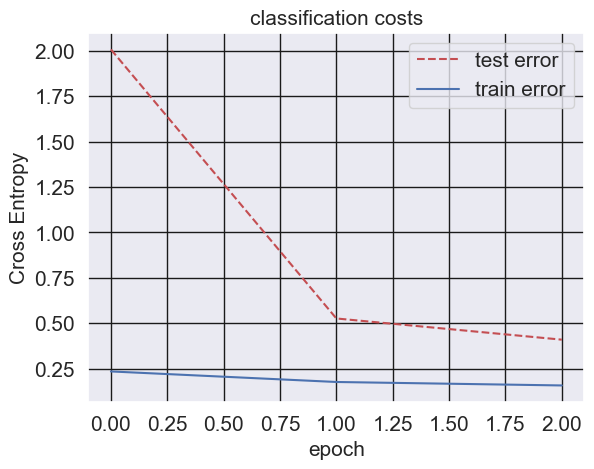

<Figure size 640x480 with 0 Axes>

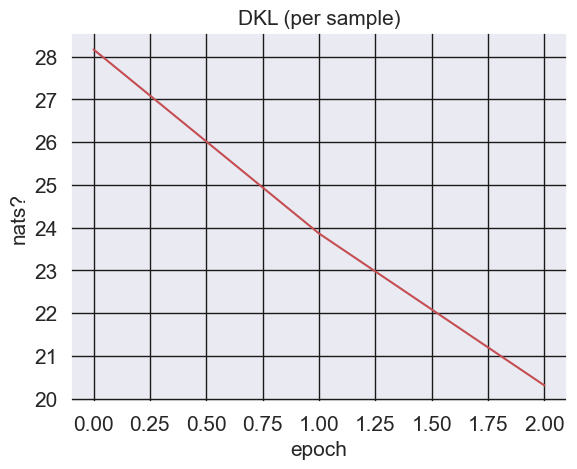

<Figure size 640x480 with 0 Axes>

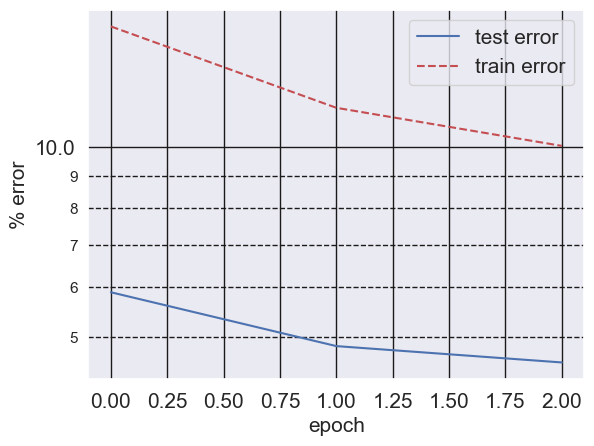

<Figure size 640x480 with 0 Axes>

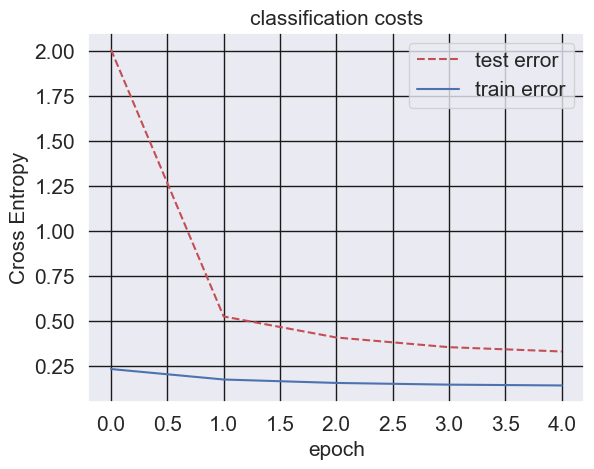

<Figure size 640x480 with 0 Axes>

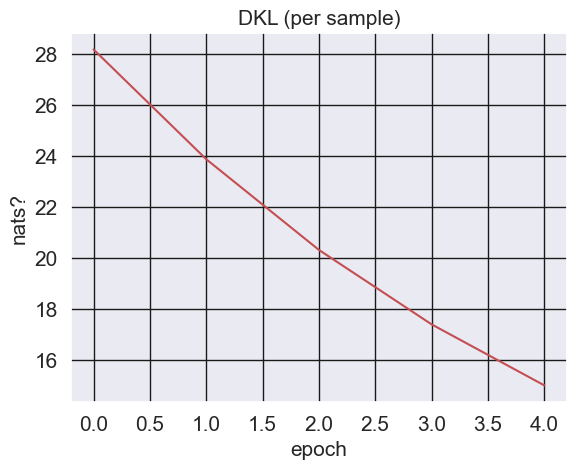

<Figure size 640x480 with 0 Axes>

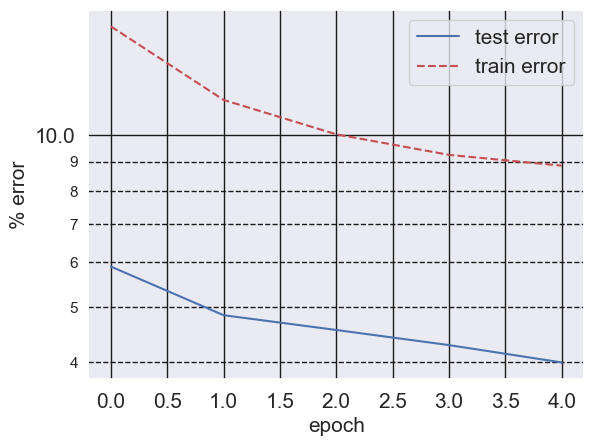

<Figure size 640x480 with 0 Axes>

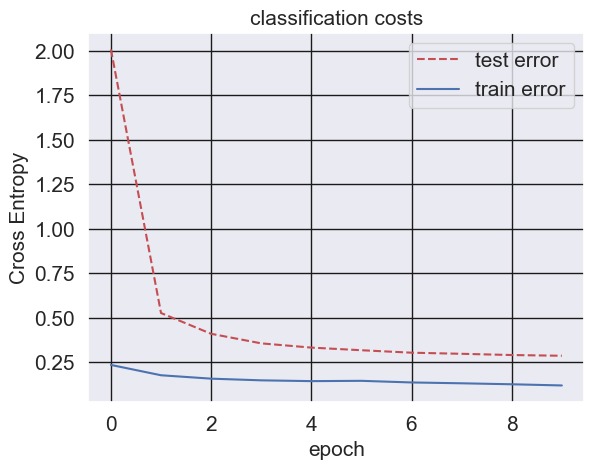

<Figure size 640x480 with 0 Axes>

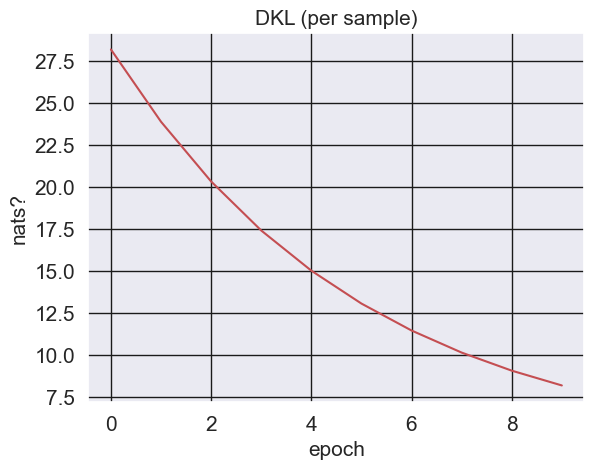

<Figure size 640x480 with 0 Axes>

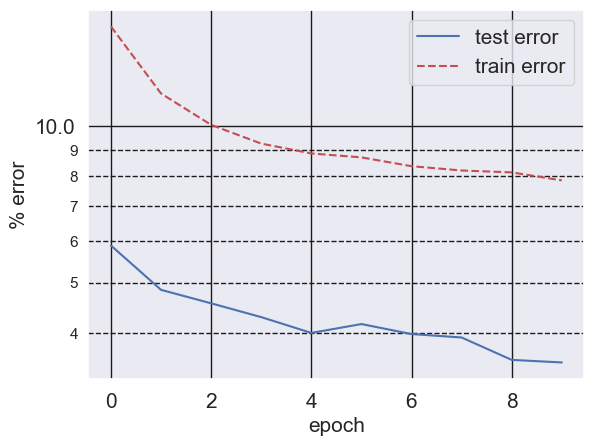

<Figure size 640x480 with 0 Axes>

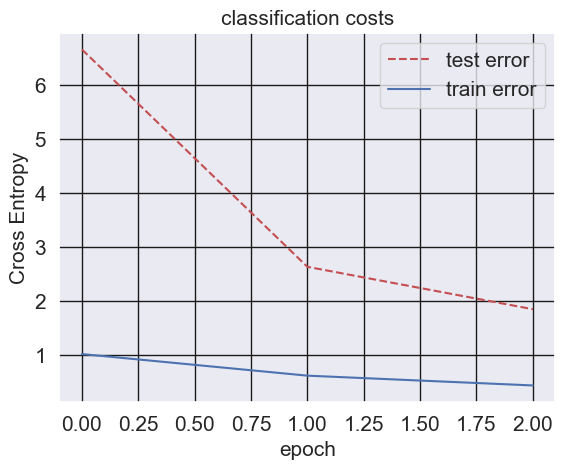

<Figure size 640x480 with 0 Axes>

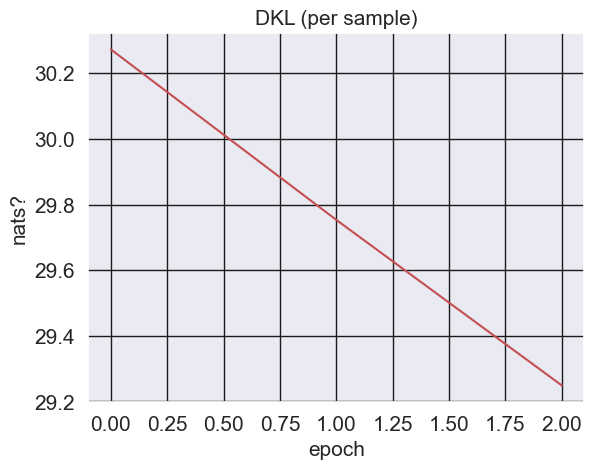

<Figure size 640x480 with 0 Axes>

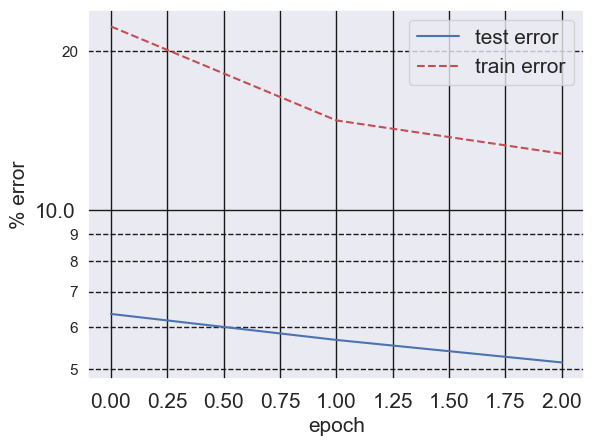

<Figure size 640x480 with 0 Axes>

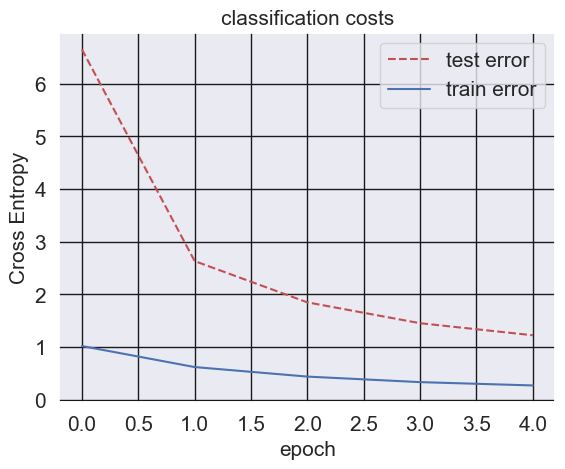

<Figure size 640x480 with 0 Axes>

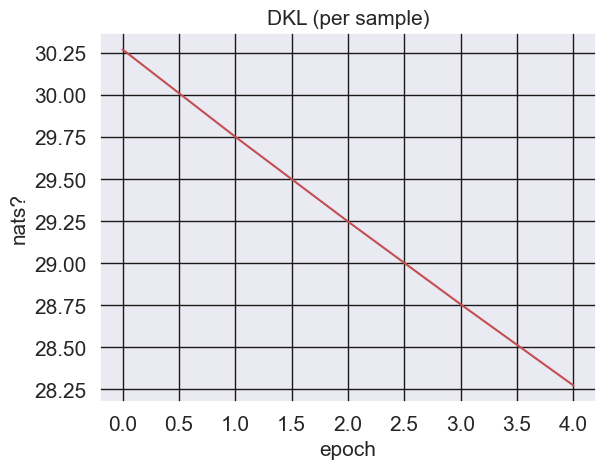

<Figure size 640x480 with 0 Axes>

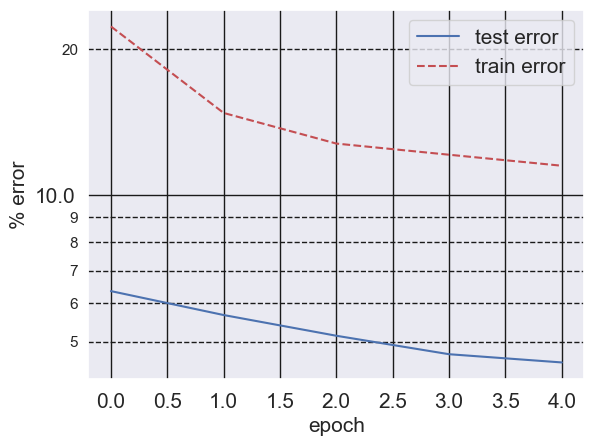

<Figure size 640x480 with 0 Axes>

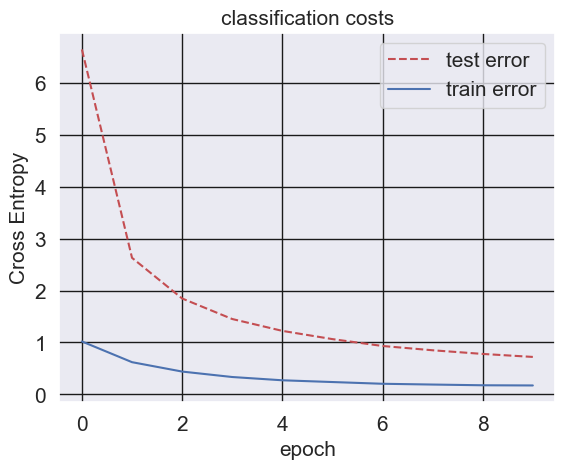

<Figure size 640x480 with 0 Axes>

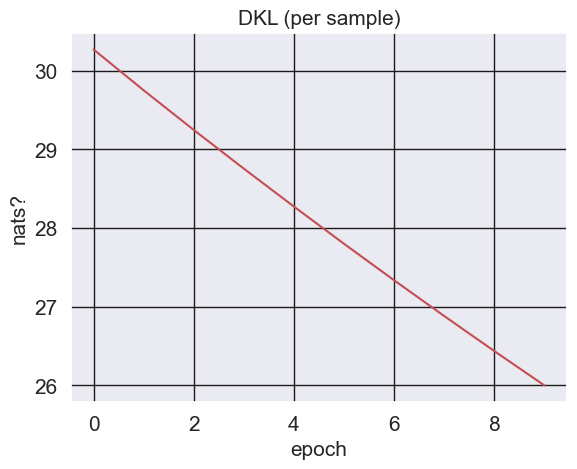

<Figure size 640x480 with 0 Axes>

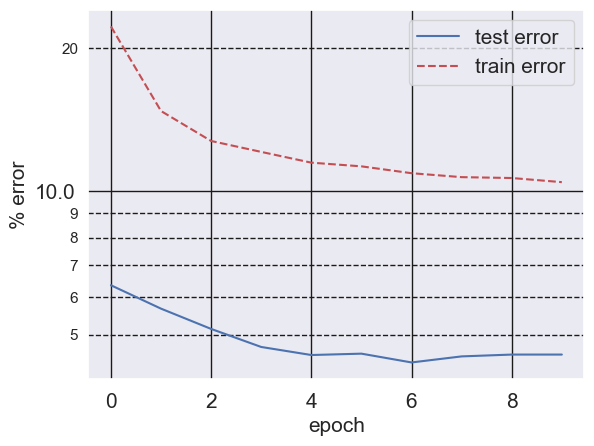

<Figure size 640x480 with 0 Axes>

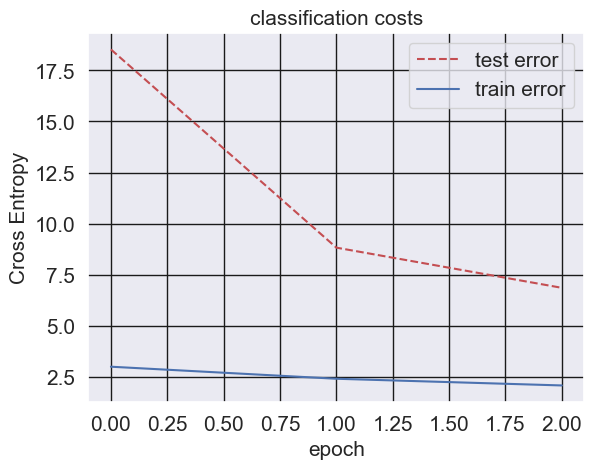

<Figure size 640x480 with 0 Axes>

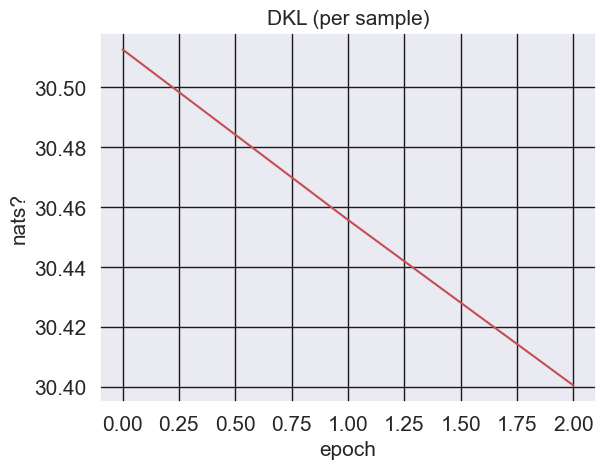

<Figure size 640x480 with 0 Axes>

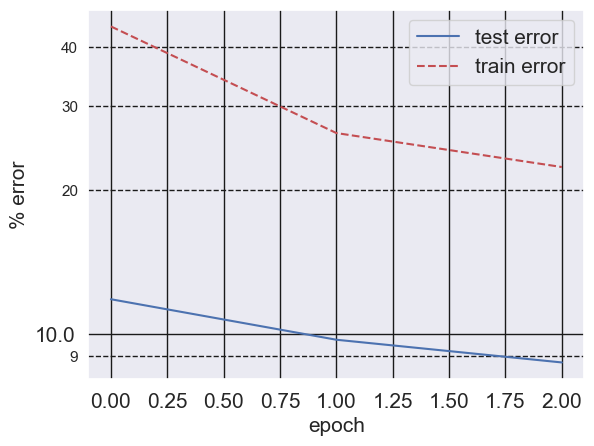

<Figure size 640x480 with 0 Axes>

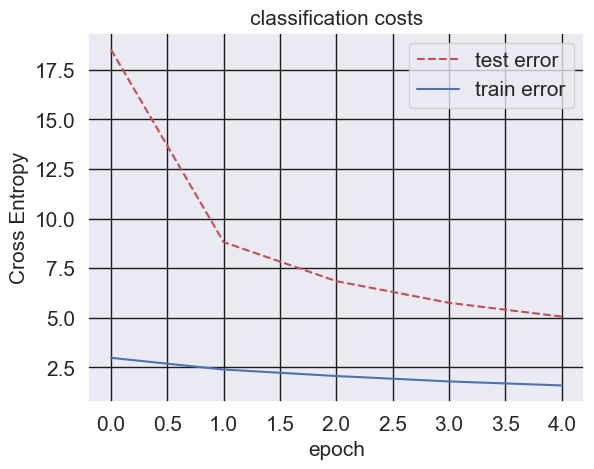

<Figure size 640x480 with 0 Axes>

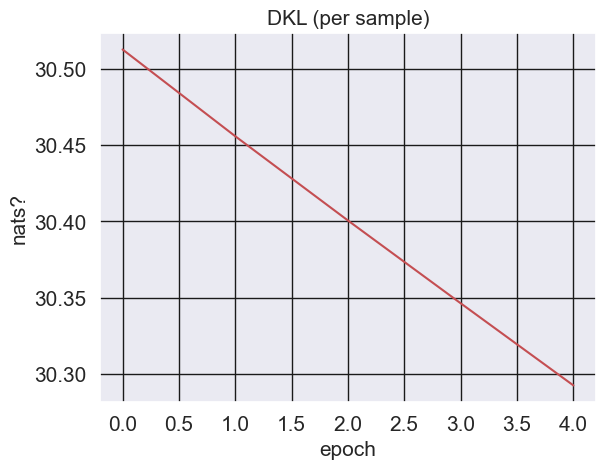

<Figure size 640x480 with 0 Axes>

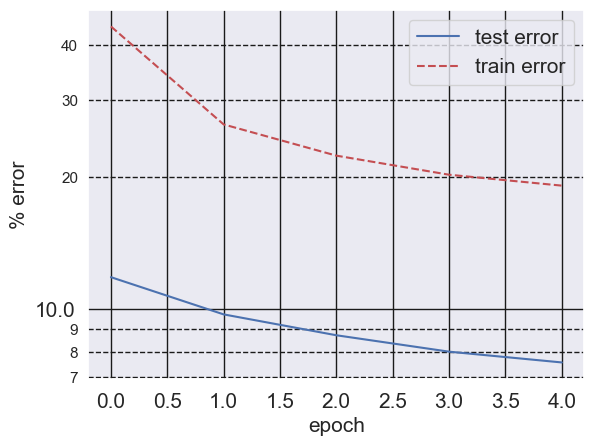

<Figure size 640x480 with 0 Axes>

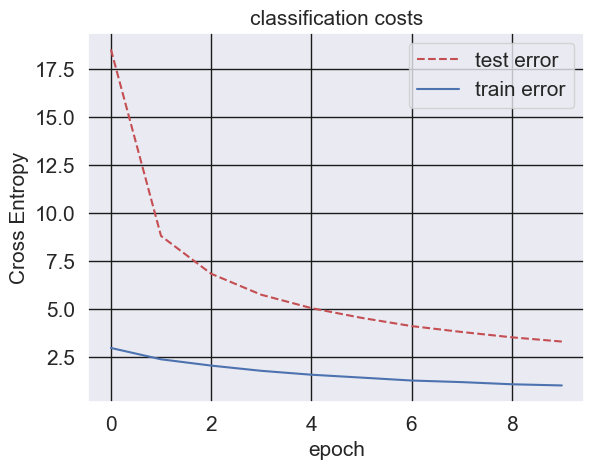

<Figure size 640x480 with 0 Axes>

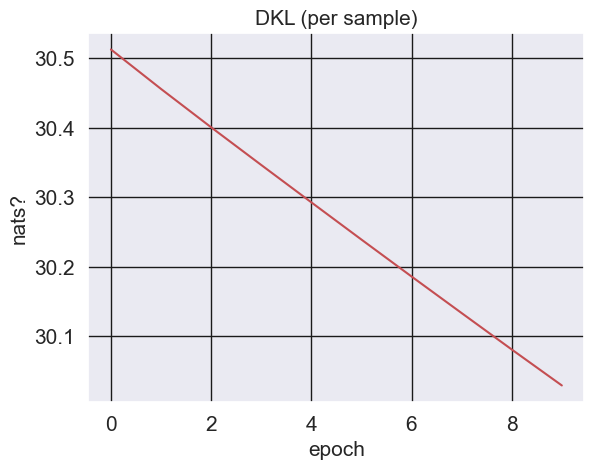

<Figure size 640x480 with 0 Axes>

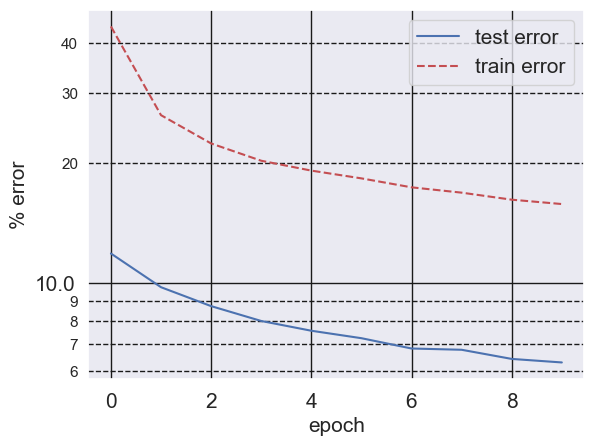

<Figure size 640x480 with 0 Axes>

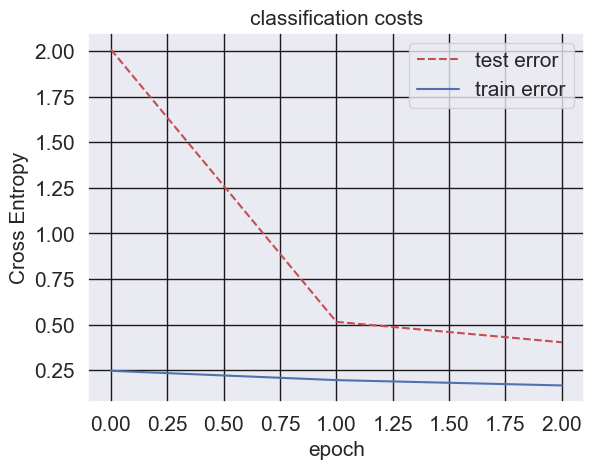

<Figure size 640x480 with 0 Axes>

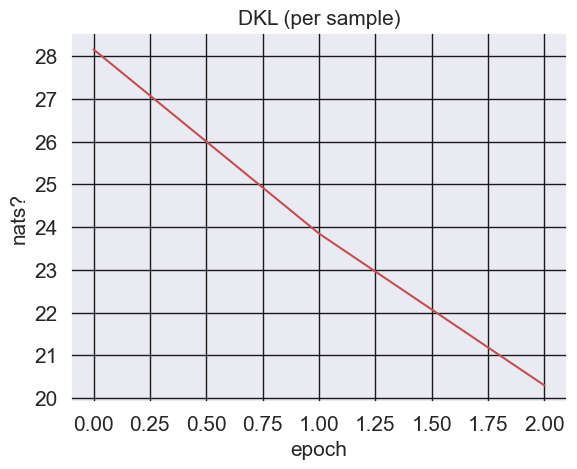

<Figure size 640x480 with 0 Axes>

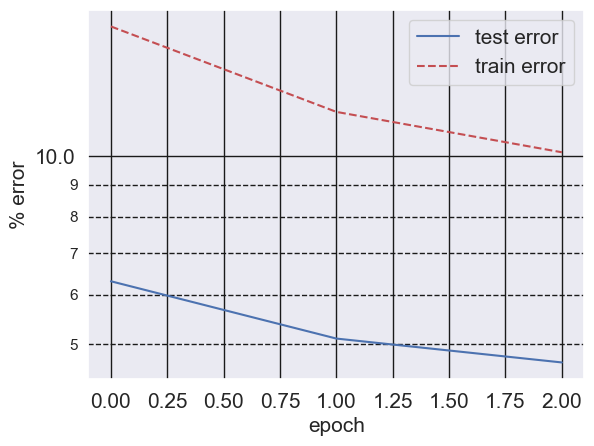

<Figure size 640x480 with 0 Axes>

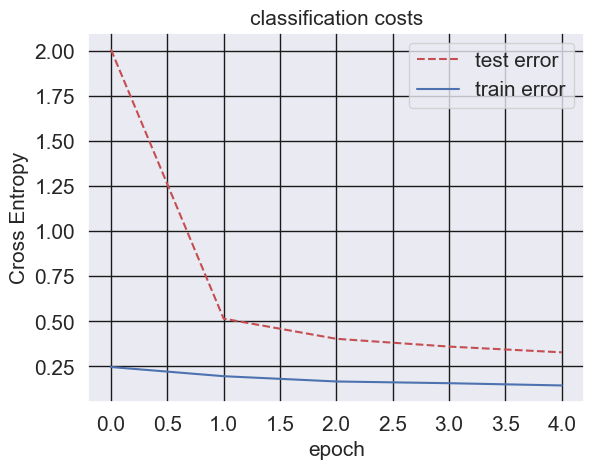

<Figure size 640x480 with 0 Axes>

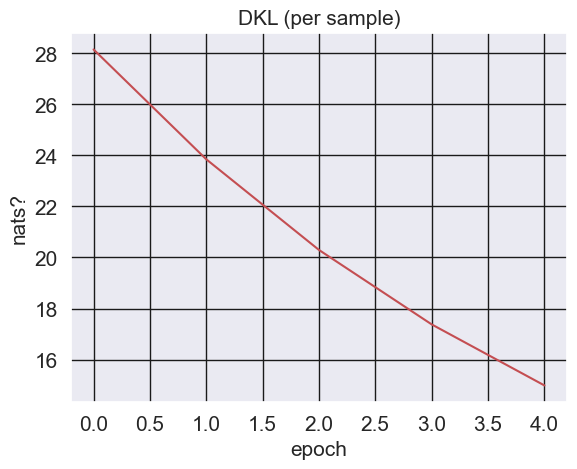

<Figure size 640x480 with 0 Axes>

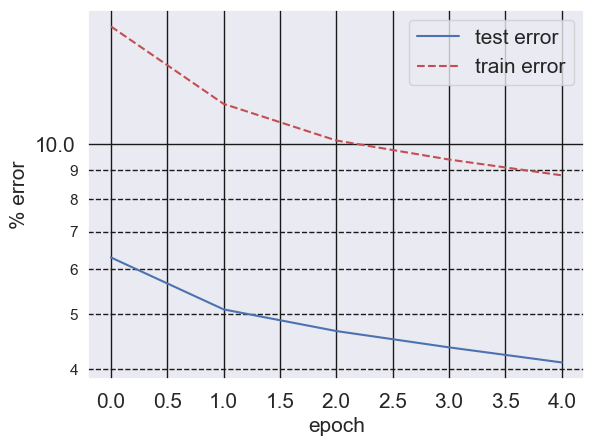

<Figure size 640x480 with 0 Axes>

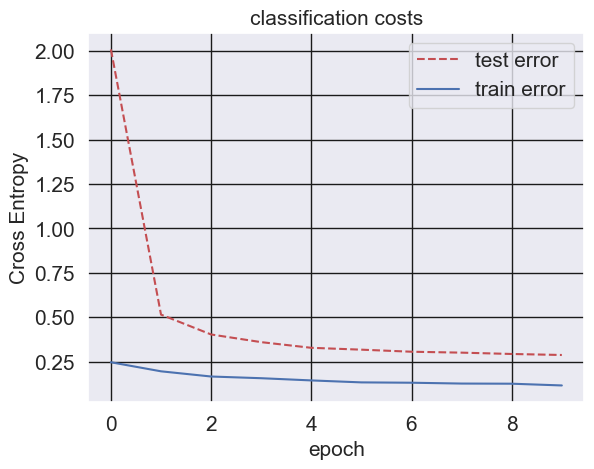

<Figure size 640x480 with 0 Axes>

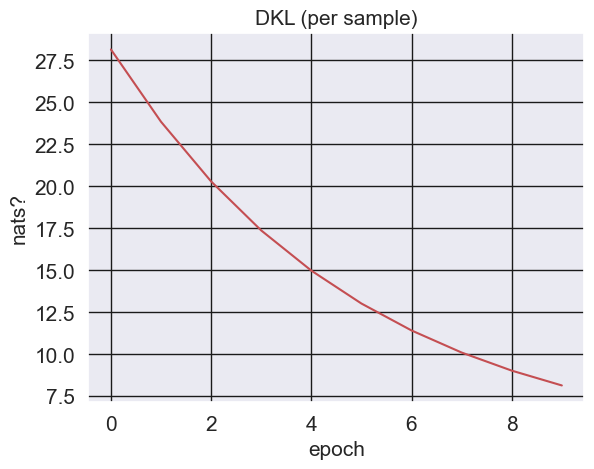

<Figure size 640x480 with 0 Axes>

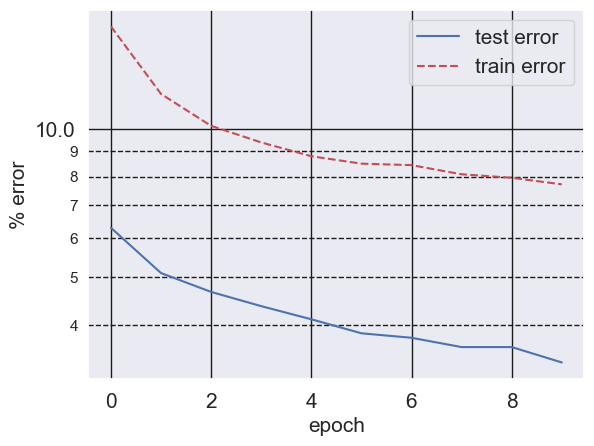

<Figure size 640x480 with 0 Axes>

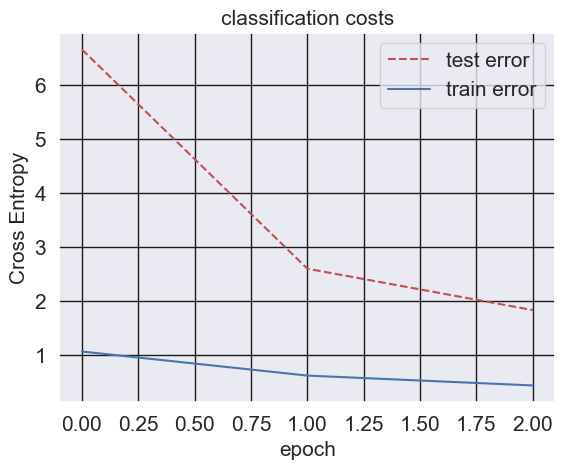

<Figure size 640x480 with 0 Axes>

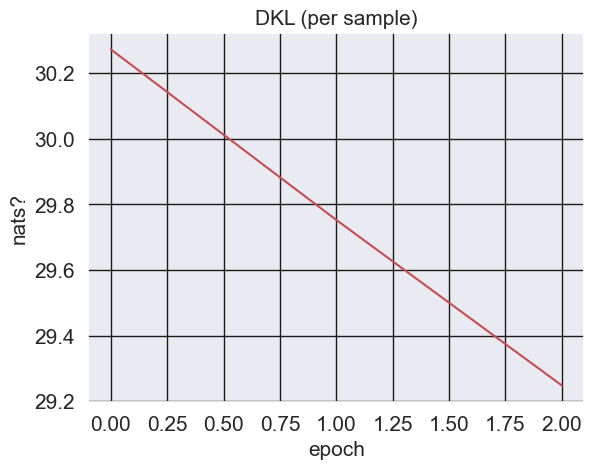

<Figure size 640x480 with 0 Axes>

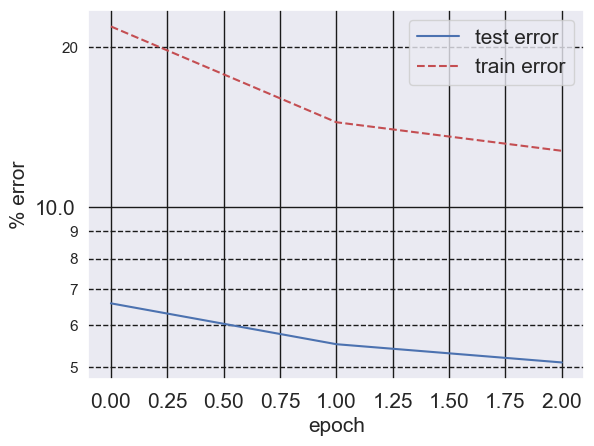

<Figure size 640x480 with 0 Axes>

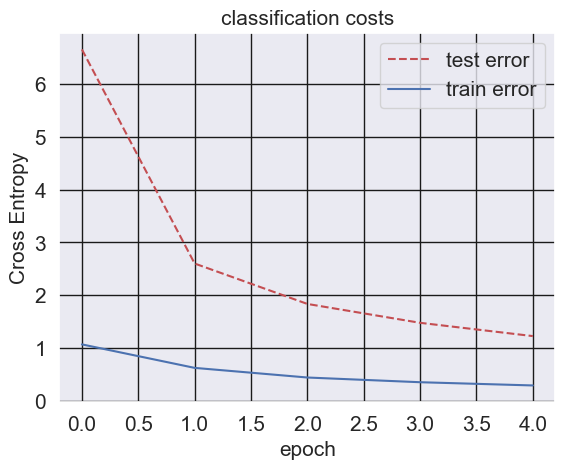

<Figure size 640x480 with 0 Axes>

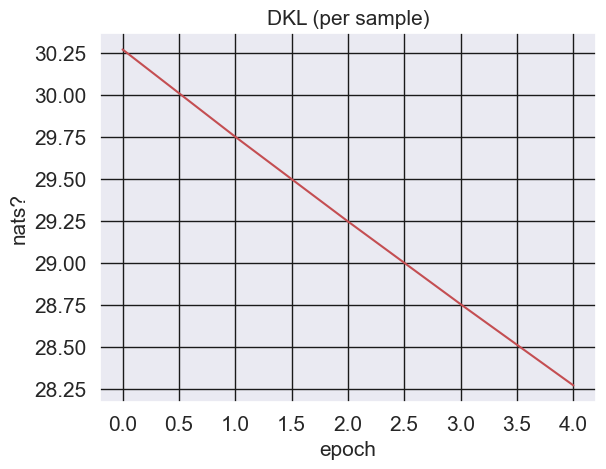

<Figure size 640x480 with 0 Axes>

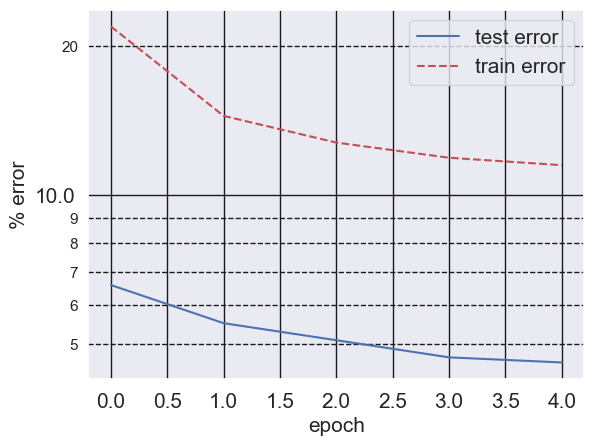

<Figure size 640x480 with 0 Axes>

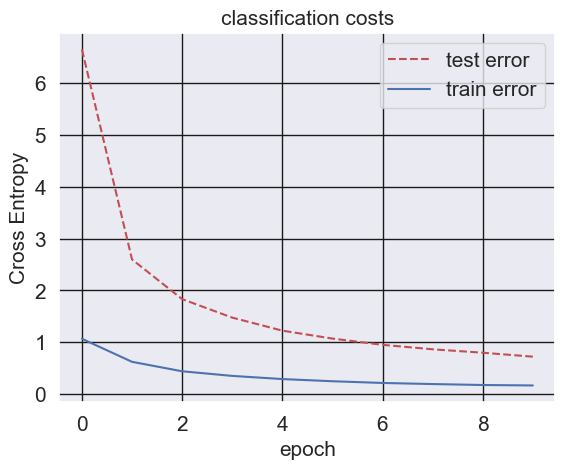

<Figure size 640x480 with 0 Axes>

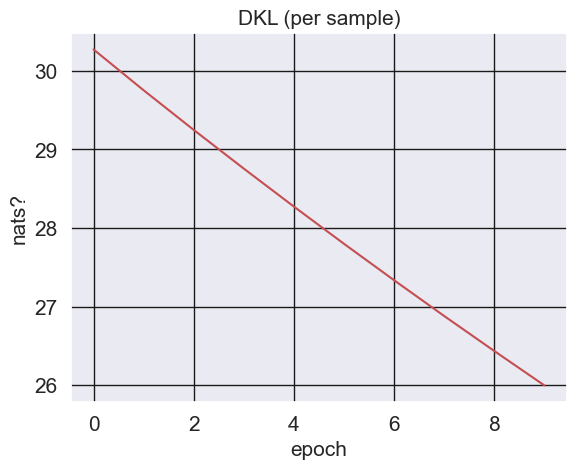

<Figure size 640x480 with 0 Axes>

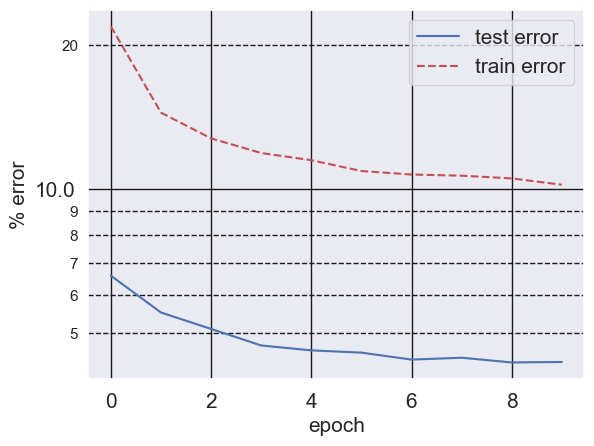

<Figure size 640x480 with 0 Axes>

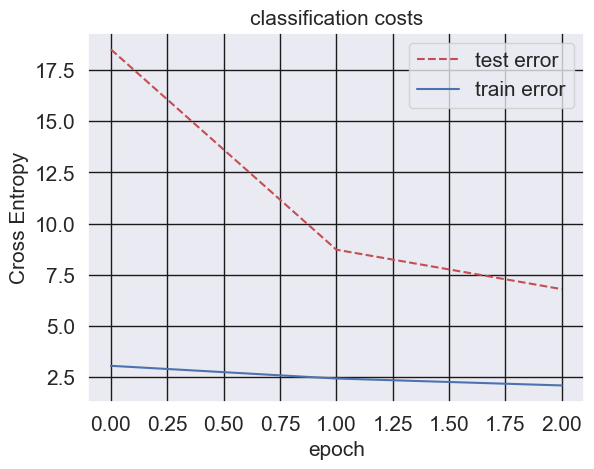

<Figure size 640x480 with 0 Axes>

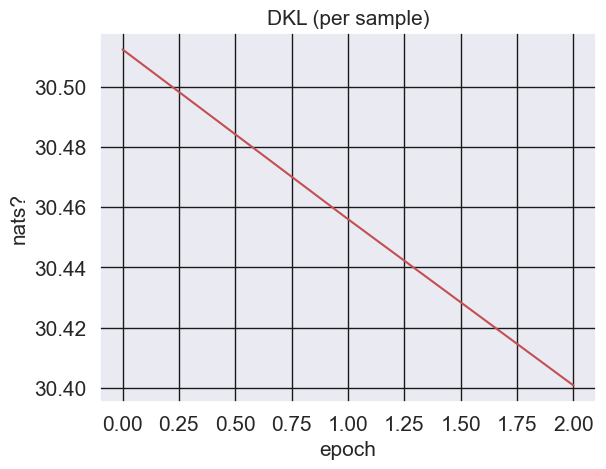

<Figure size 640x480 with 0 Axes>

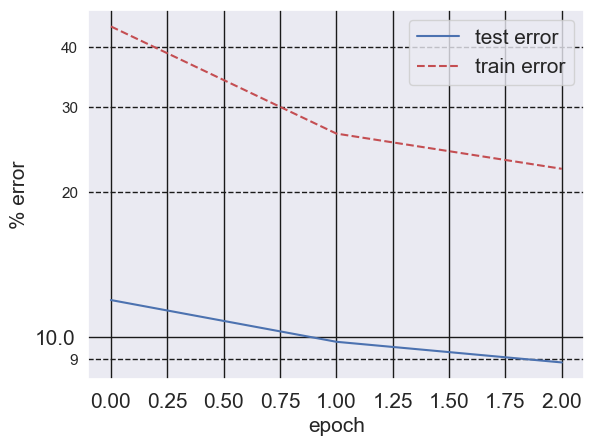

<Figure size 640x480 with 0 Axes>

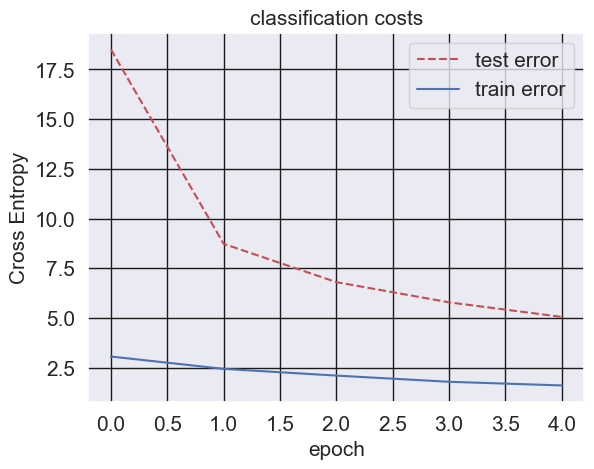

<Figure size 640x480 with 0 Axes>

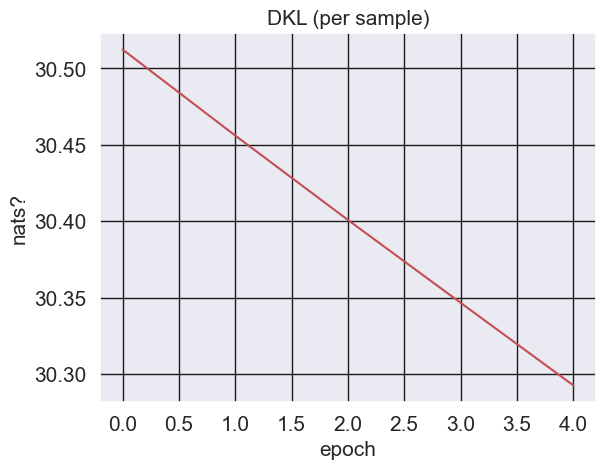

<Figure size 640x480 with 0 Axes>

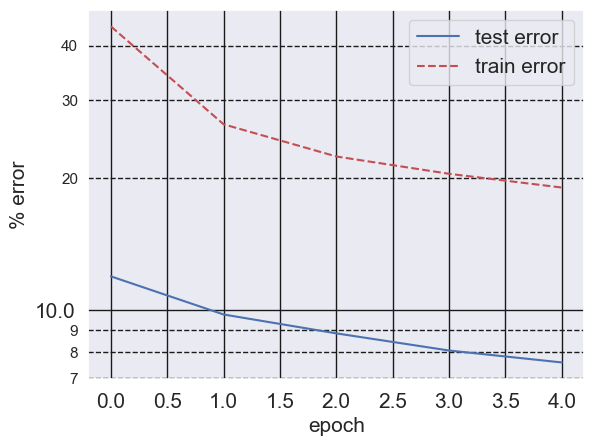

<Figure size 640x480 with 0 Axes>

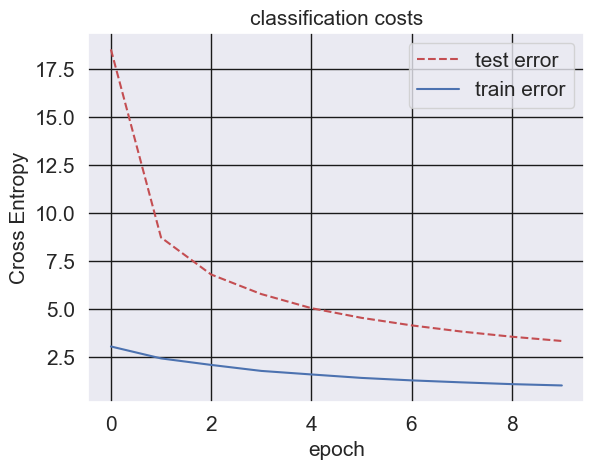

<Figure size 640x480 with 0 Axes>

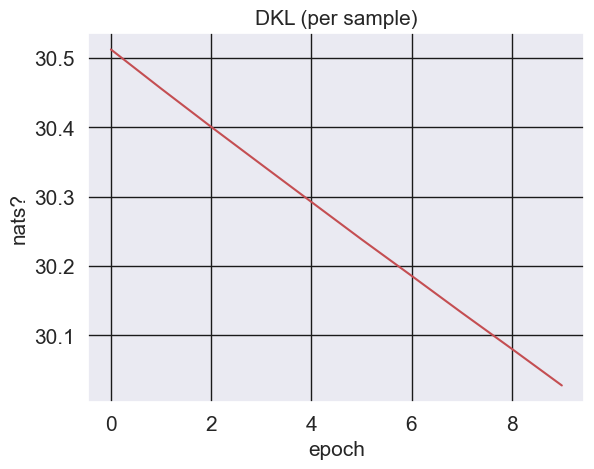

<Figure size 640x480 with 0 Axes>

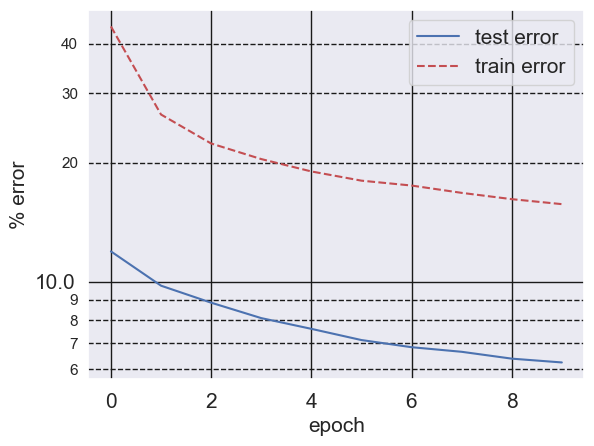

<Figure size 640x480 with 0 Axes>

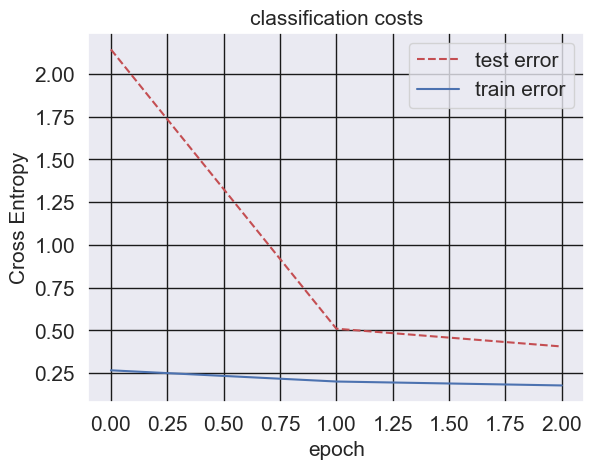

<Figure size 640x480 with 0 Axes>

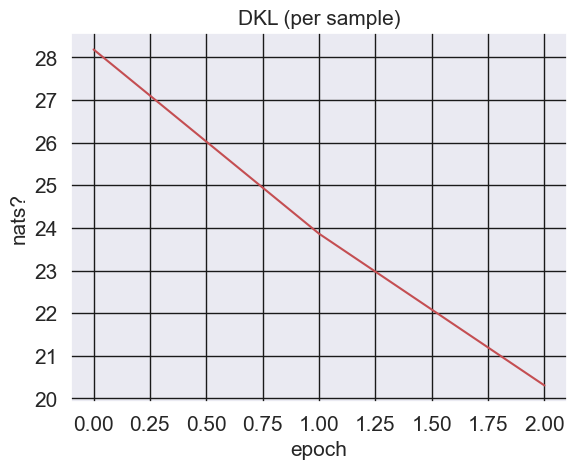

<Figure size 640x480 with 0 Axes>

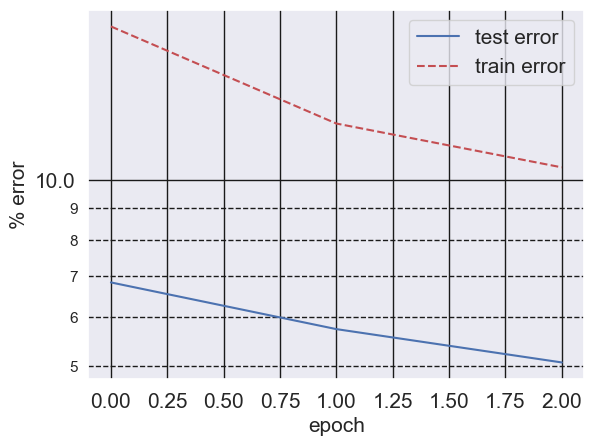

<Figure size 640x480 with 0 Axes>

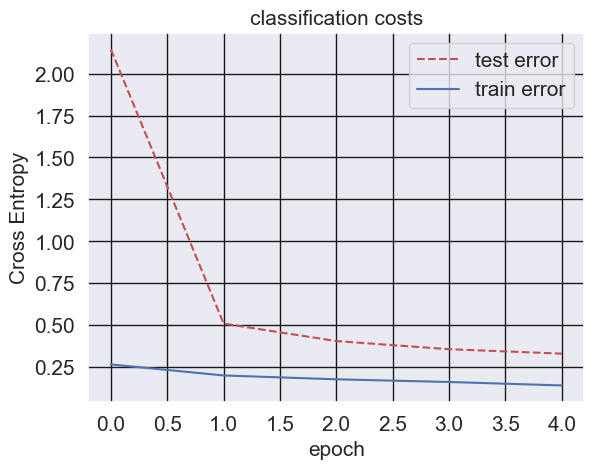

<Figure size 640x480 with 0 Axes>

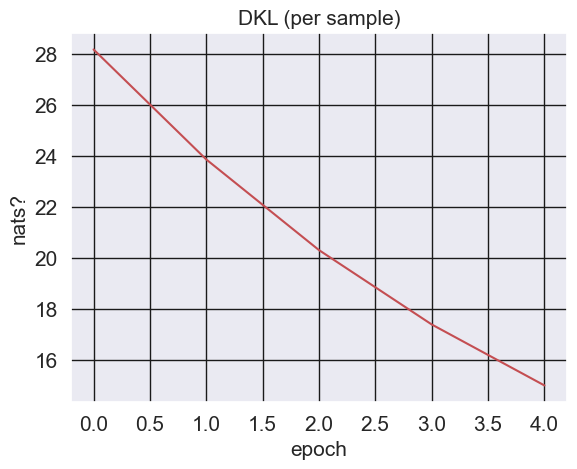

<Figure size 640x480 with 0 Axes>

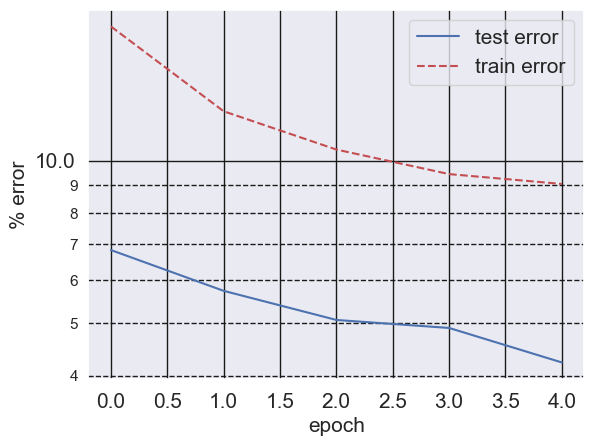

<Figure size 640x480 with 0 Axes>

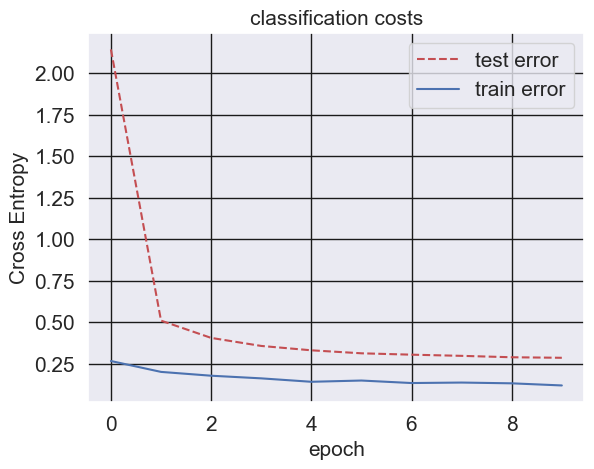

<Figure size 640x480 with 0 Axes>

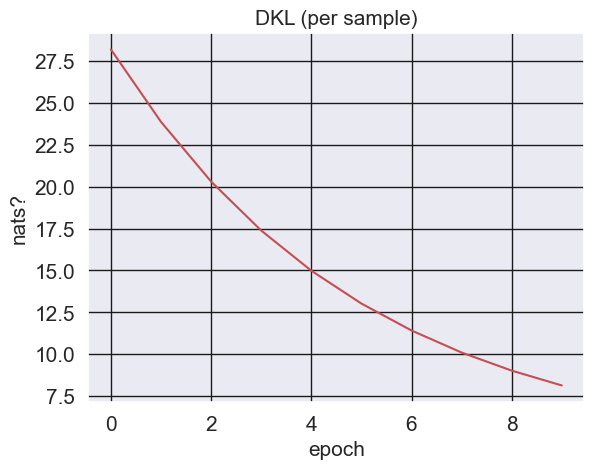

<Figure size 640x480 with 0 Axes>

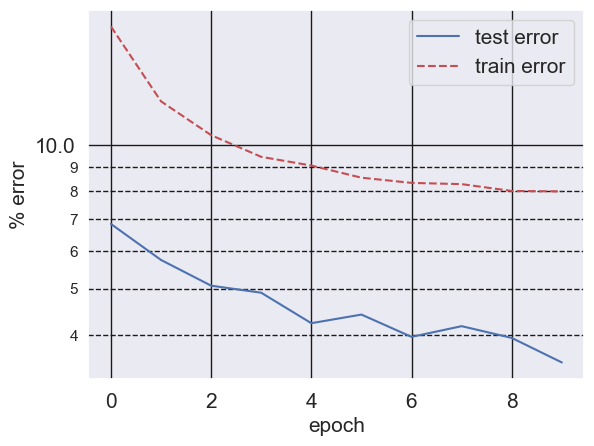

<Figure size 640x480 with 0 Axes>

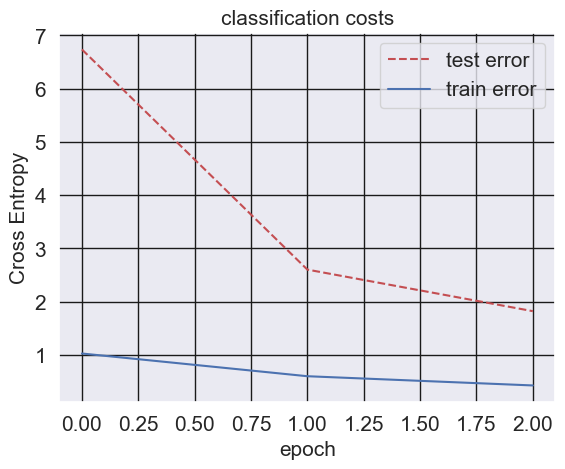

<Figure size 640x480 with 0 Axes>

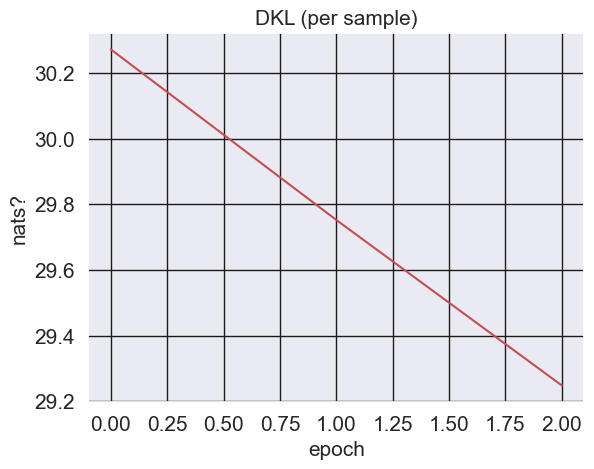

<Figure size 640x480 with 0 Axes>

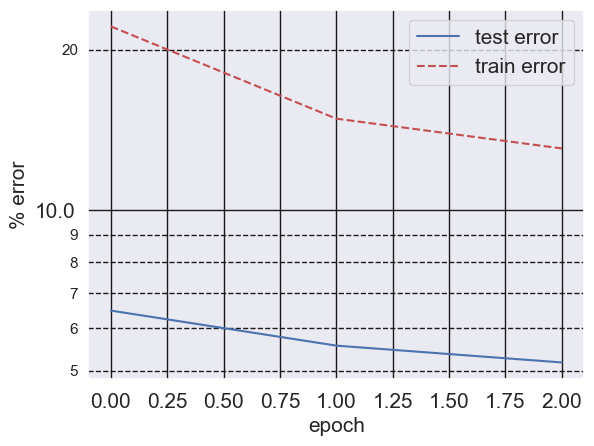

<Figure size 640x480 with 0 Axes>

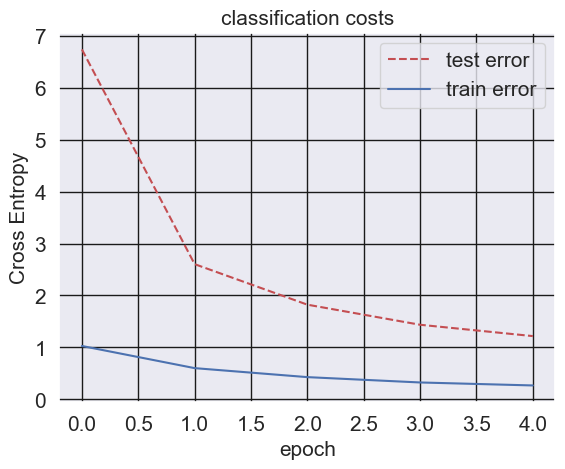

<Figure size 640x480 with 0 Axes>

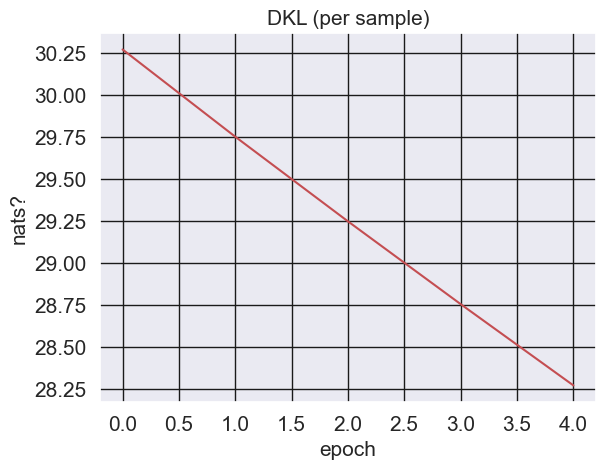

<Figure size 640x480 with 0 Axes>

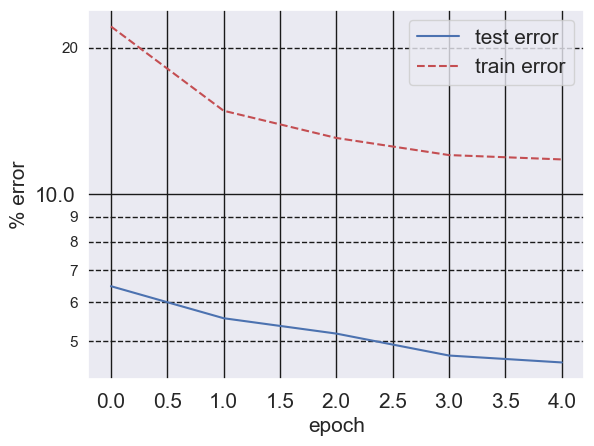

<Figure size 640x480 with 0 Axes>

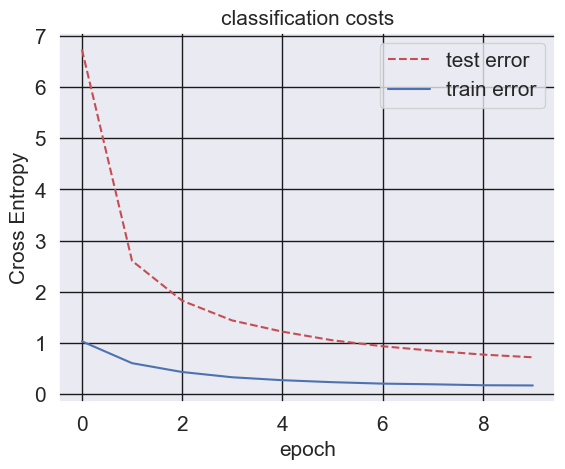

<Figure size 640x480 with 0 Axes>

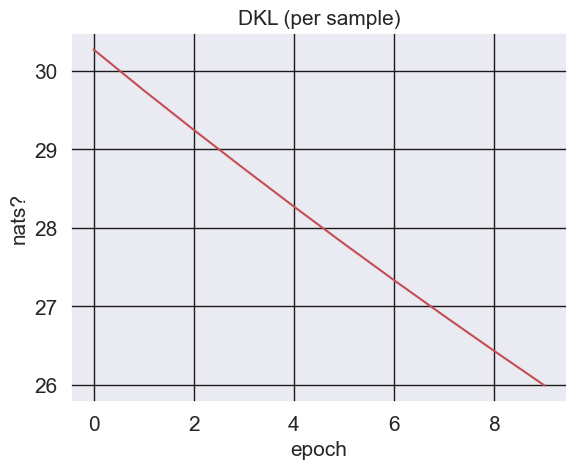

<Figure size 640x480 with 0 Axes>

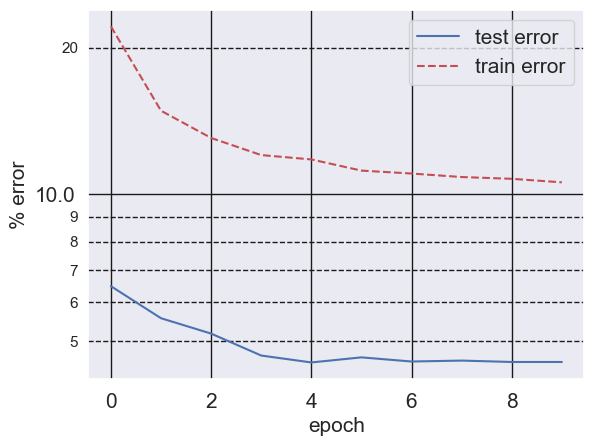

<Figure size 640x480 with 0 Axes>

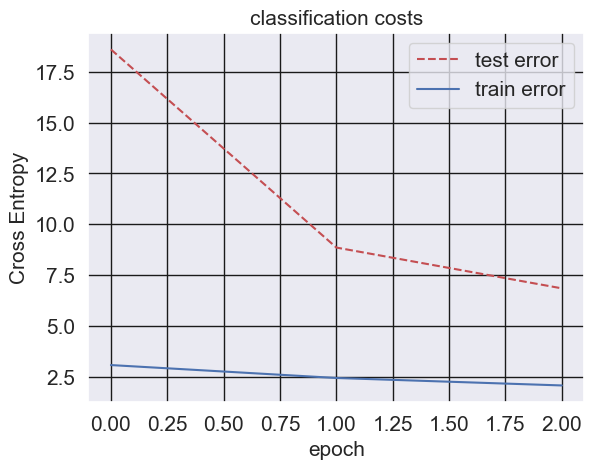

<Figure size 640x480 with 0 Axes>

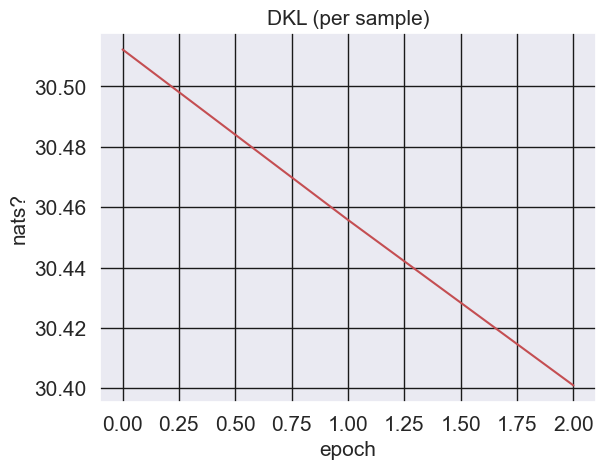

<Figure size 640x480 with 0 Axes>

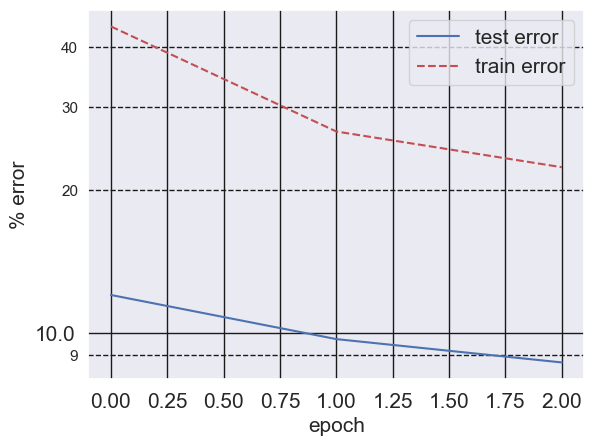

<Figure size 640x480 with 0 Axes>

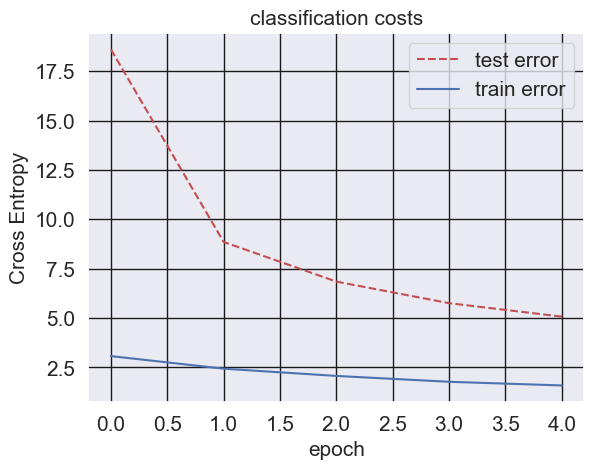

<Figure size 640x480 with 0 Axes>

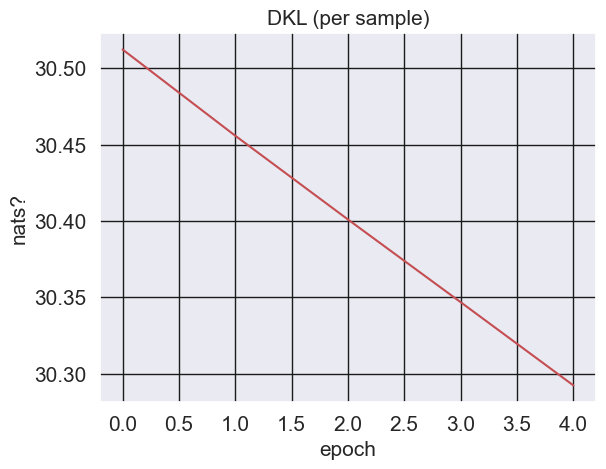

<Figure size 640x480 with 0 Axes>

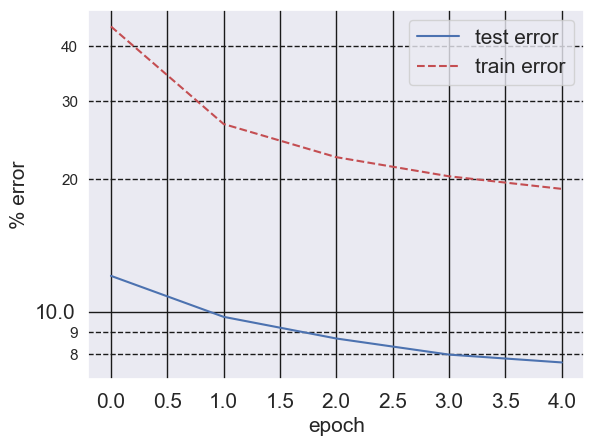

<Figure size 640x480 with 0 Axes>

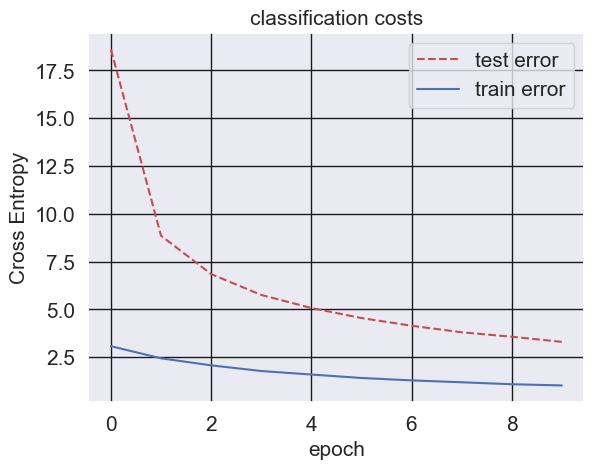

<Figure size 640x480 with 0 Axes>

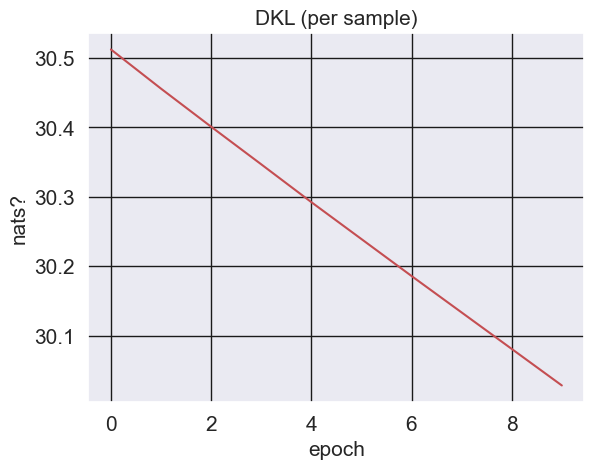

<Figure size 640x480 with 0 Axes>

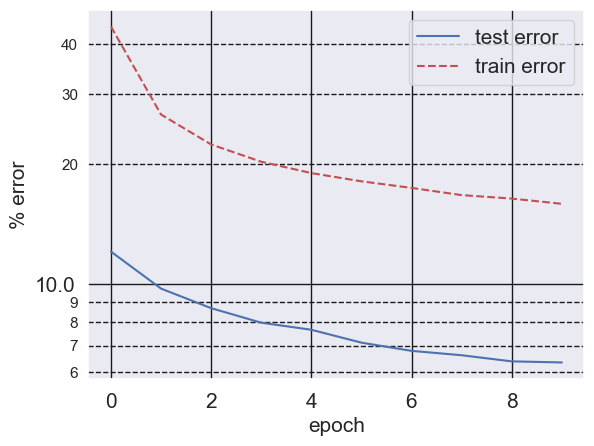

<Figure size 640x480 with 0 Axes>

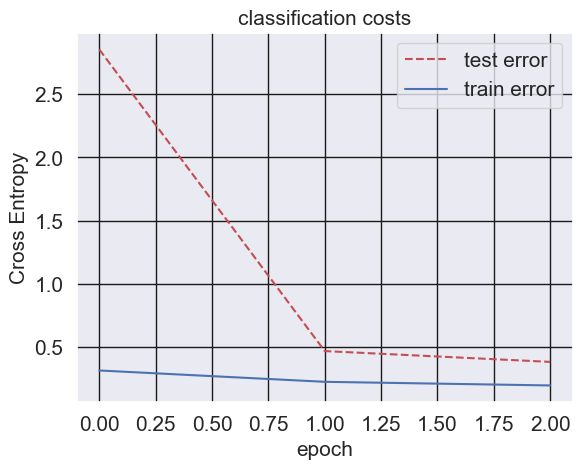

<Figure size 640x480 with 0 Axes>

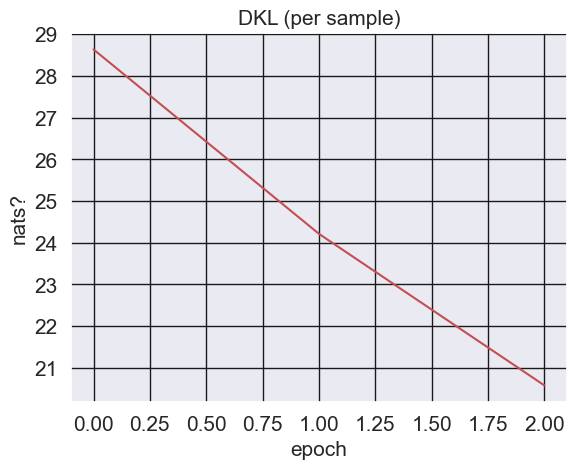

<Figure size 640x480 with 0 Axes>

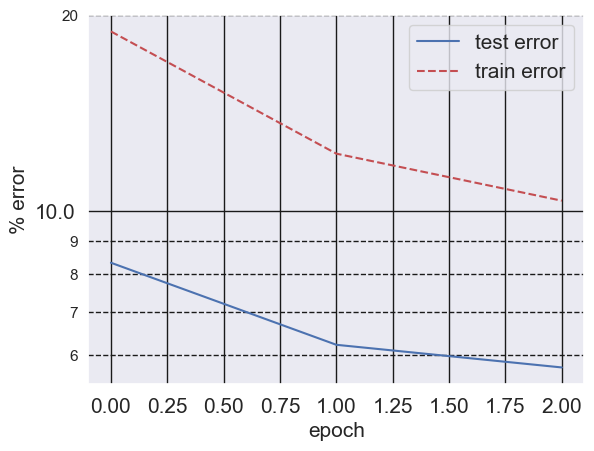

<Figure size 640x480 with 0 Axes>

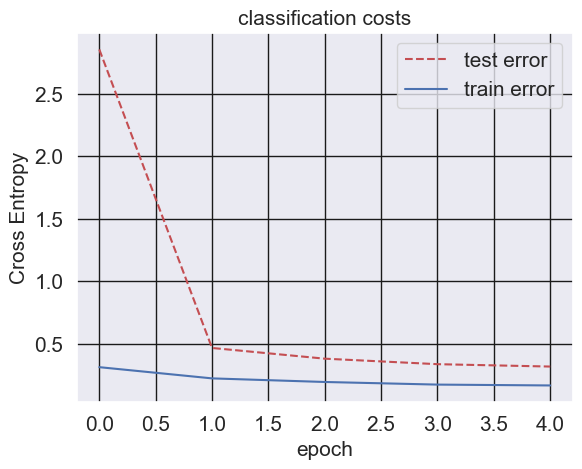

<Figure size 640x480 with 0 Axes>

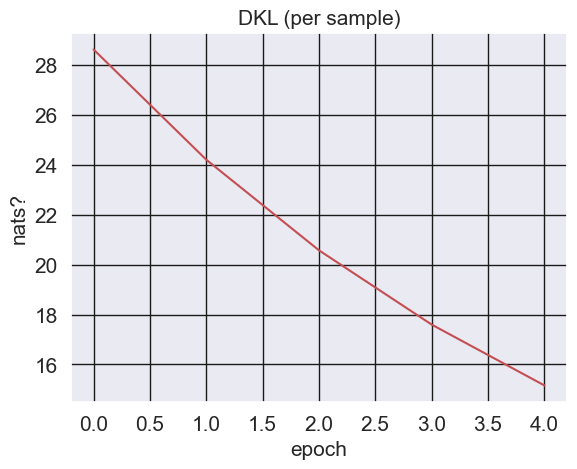

<Figure size 640x480 with 0 Axes>

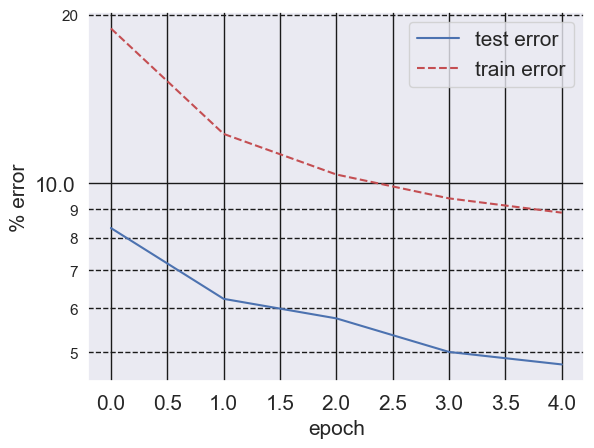

<Figure size 640x480 with 0 Axes>

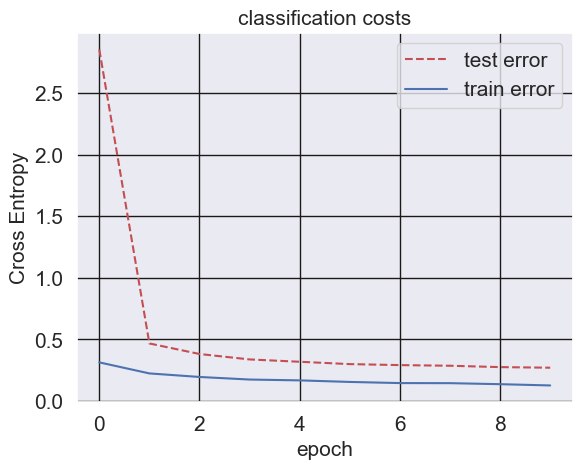

<Figure size 640x480 with 0 Axes>

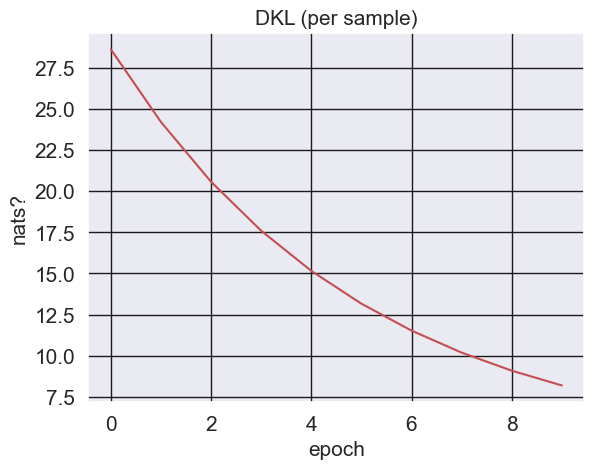

<Figure size 640x480 with 0 Axes>

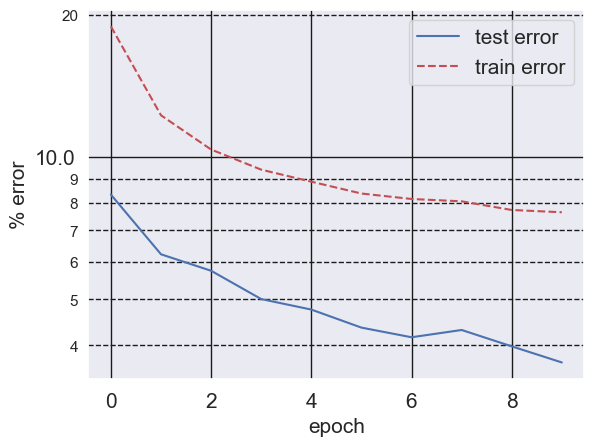

<Figure size 640x480 with 0 Axes>

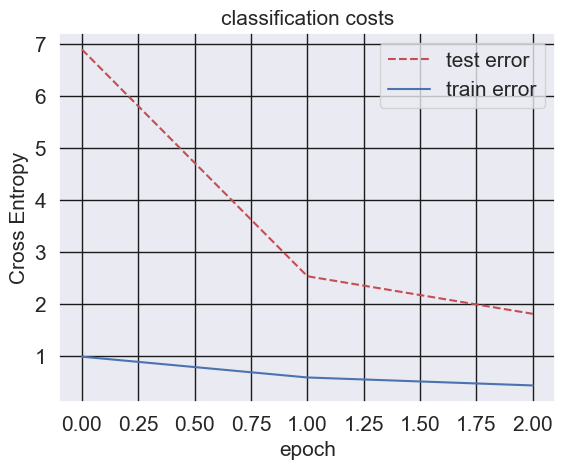

<Figure size 640x480 with 0 Axes>

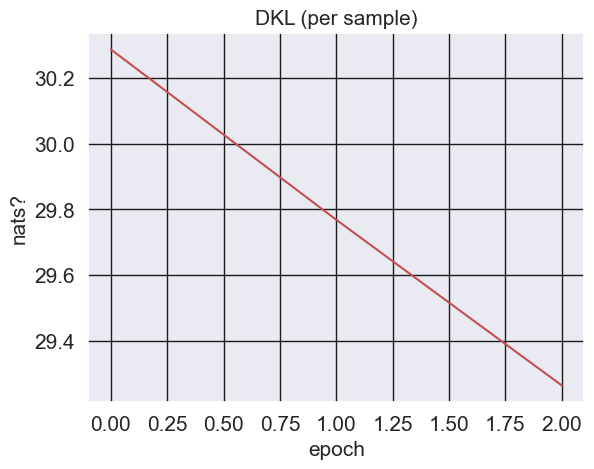

<Figure size 640x480 with 0 Axes>

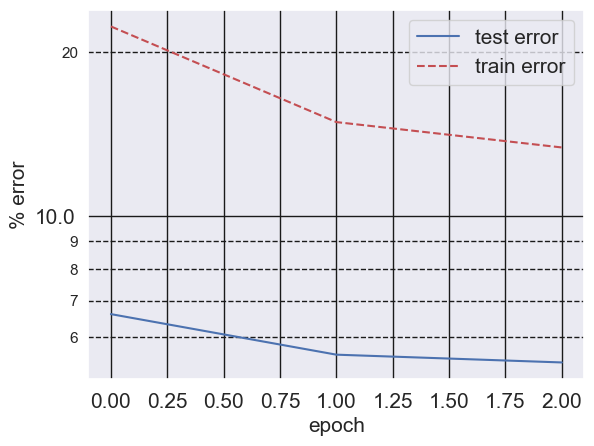

<Figure size 640x480 with 0 Axes>

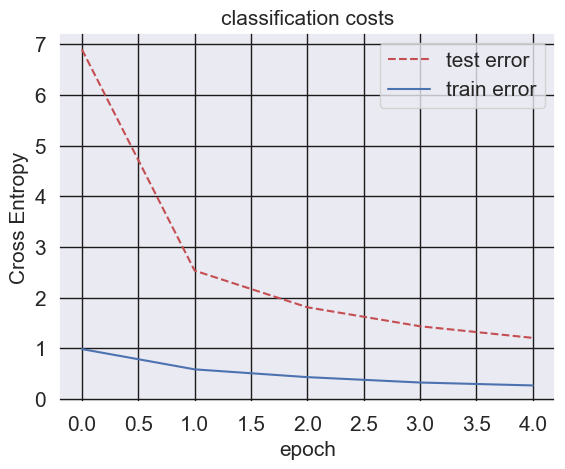

<Figure size 640x480 with 0 Axes>

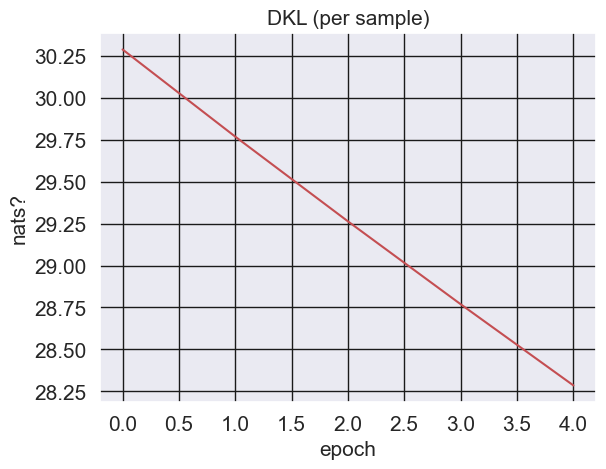

<Figure size 640x480 with 0 Axes>

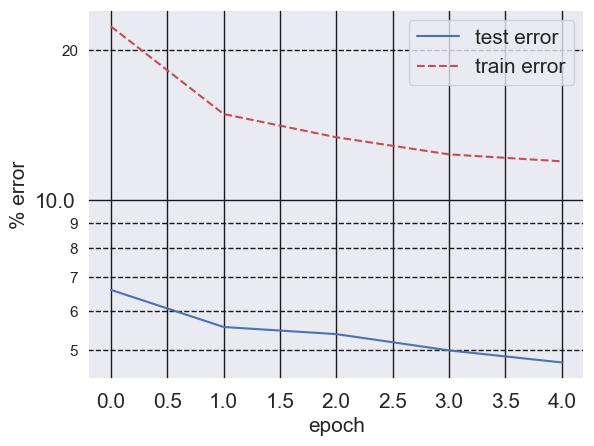

<Figure size 640x480 with 0 Axes>

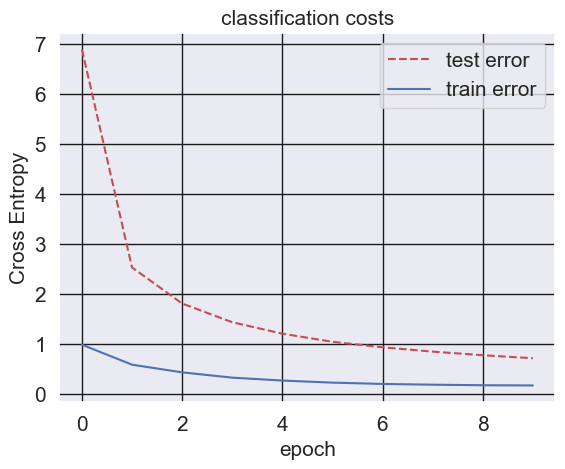

<Figure size 640x480 with 0 Axes>

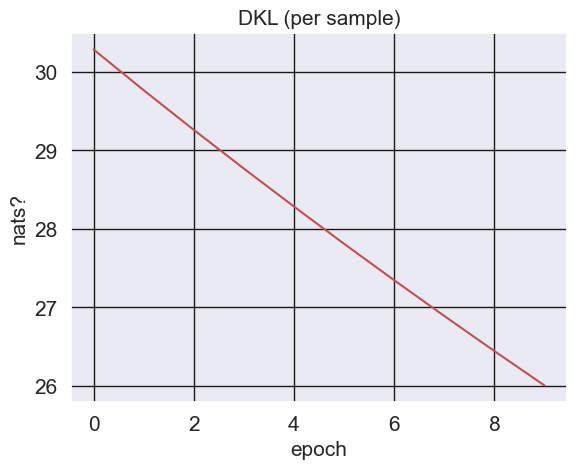

<Figure size 640x480 with 0 Axes>

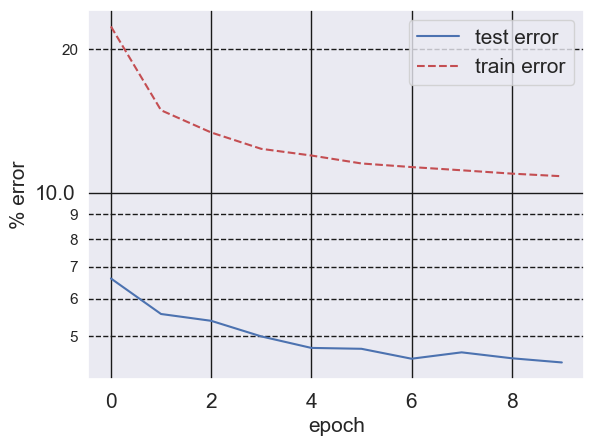

<Figure size 640x480 with 0 Axes>

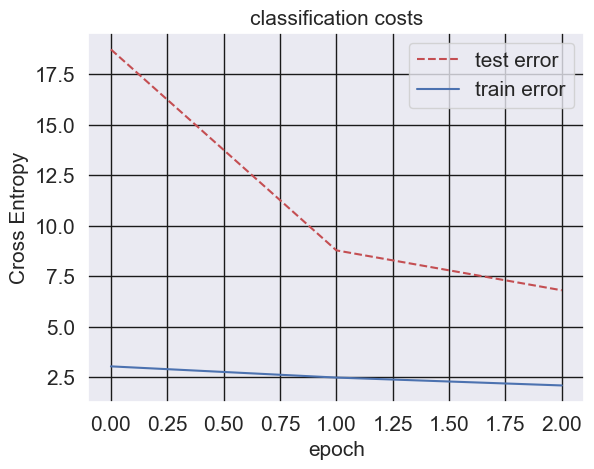

<Figure size 640x480 with 0 Axes>

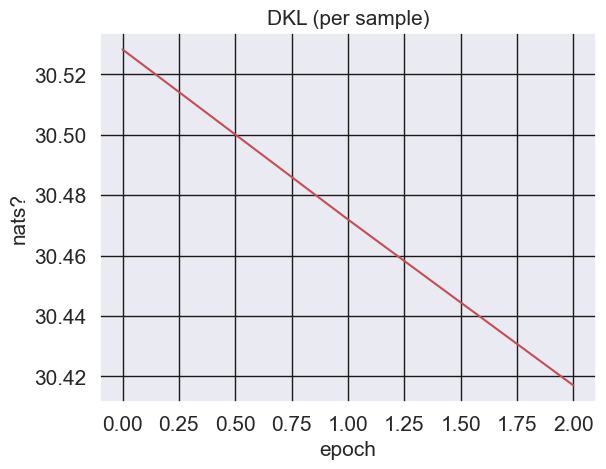

<Figure size 640x480 with 0 Axes>

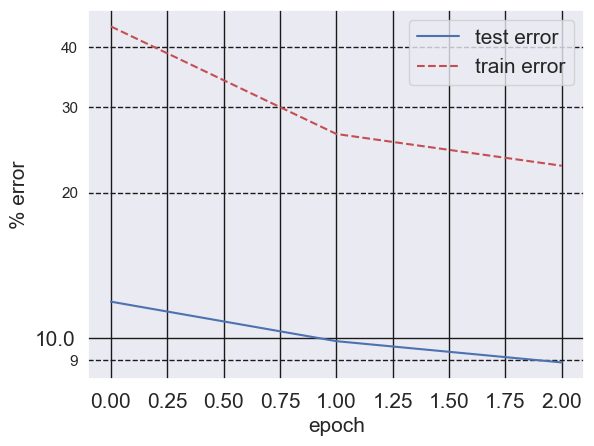

<Figure size 640x480 with 0 Axes>

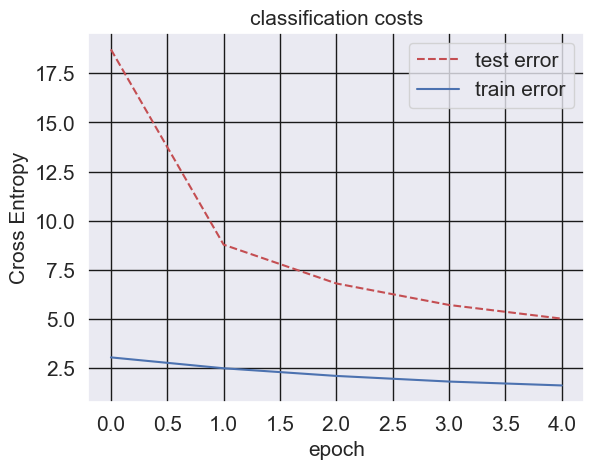

<Figure size 640x480 with 0 Axes>

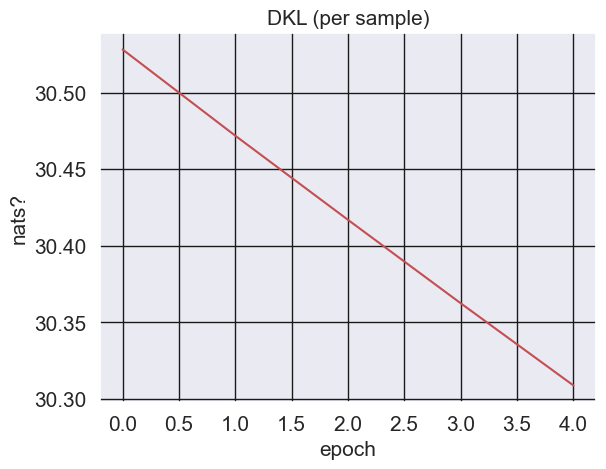

<Figure size 640x480 with 0 Axes>

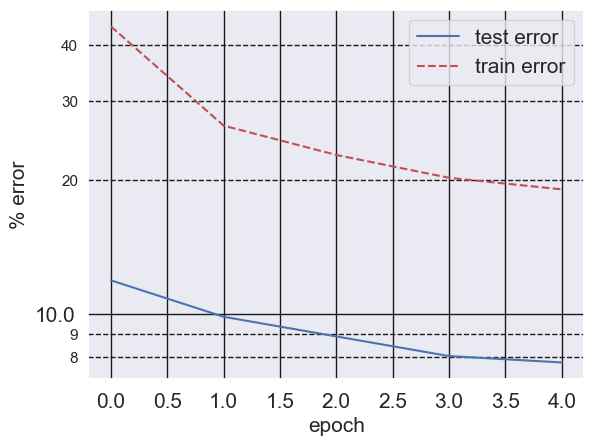

<Figure size 640x480 with 0 Axes>

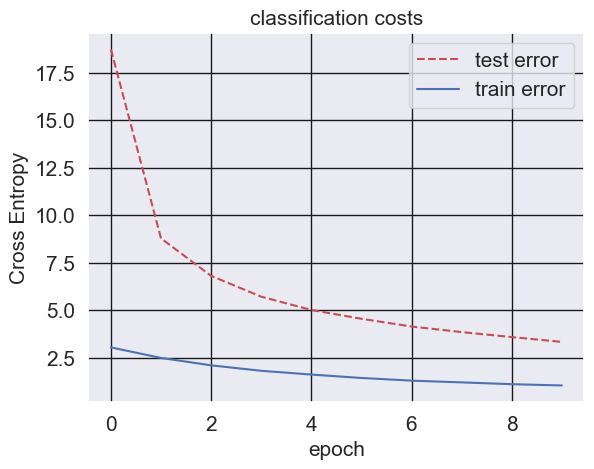

<Figure size 640x480 with 0 Axes>

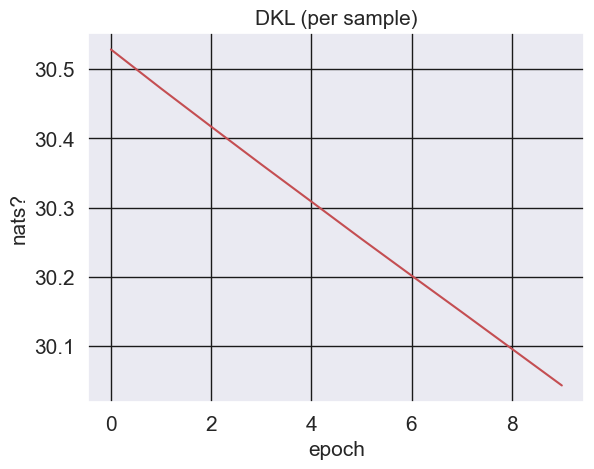

<Figure size 640x480 with 0 Axes>

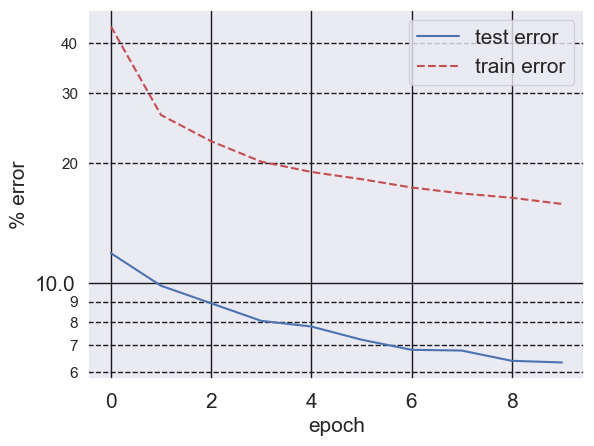

<Figure size 640x480 with 0 Axes>

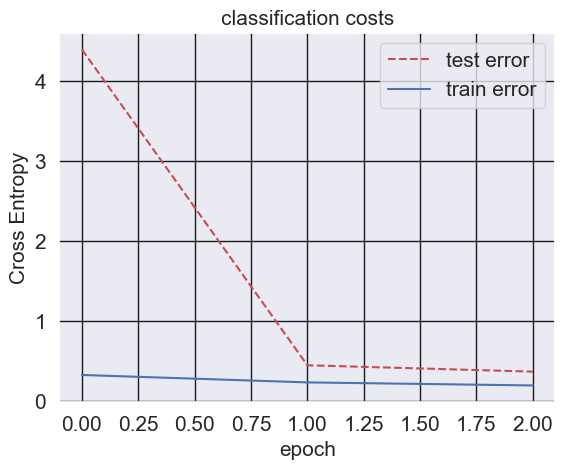

<Figure size 640x480 with 0 Axes>

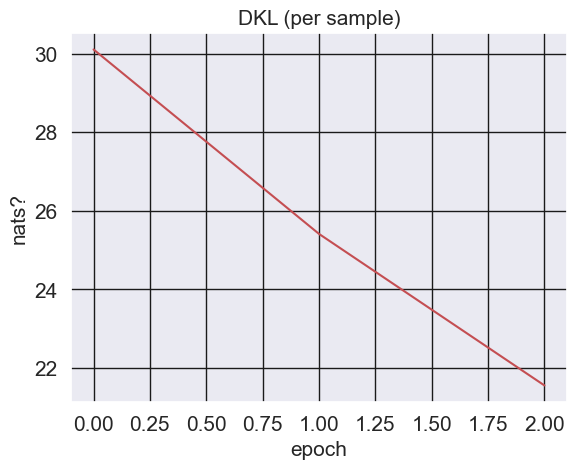

<Figure size 640x480 with 0 Axes>

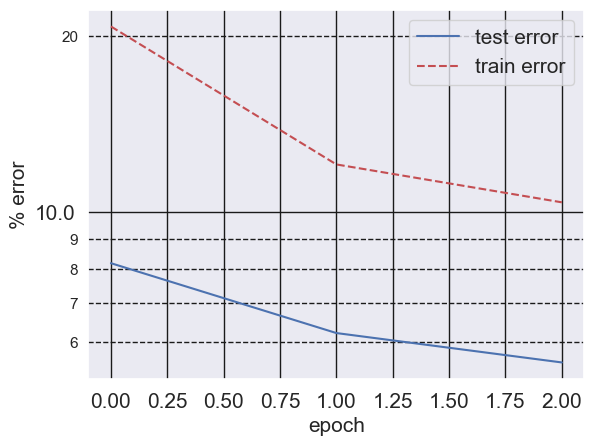

<Figure size 640x480 with 0 Axes>

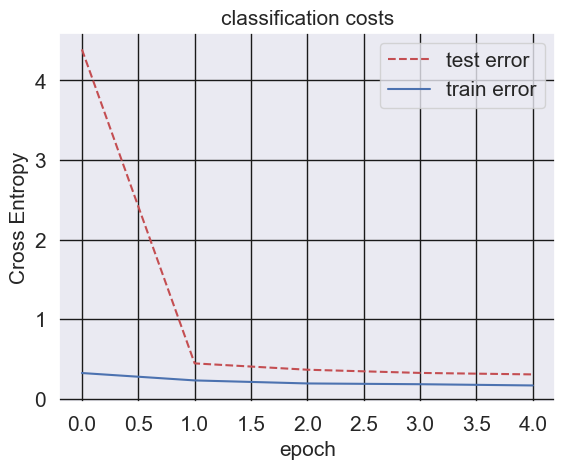

<Figure size 640x480 with 0 Axes>

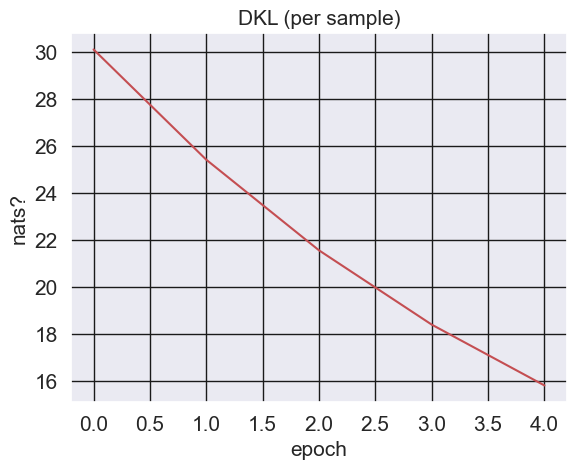

<Figure size 640x480 with 0 Axes>

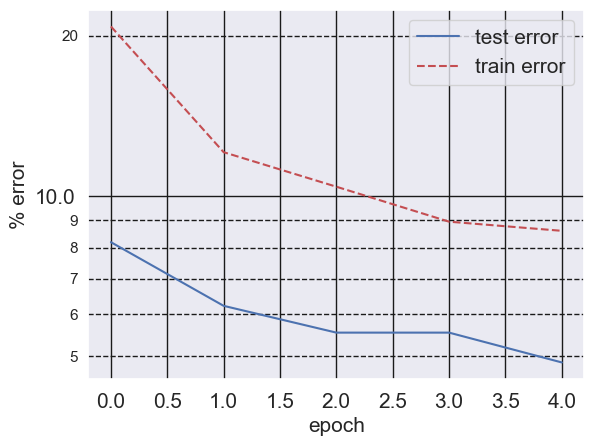

<Figure size 640x480 with 0 Axes>

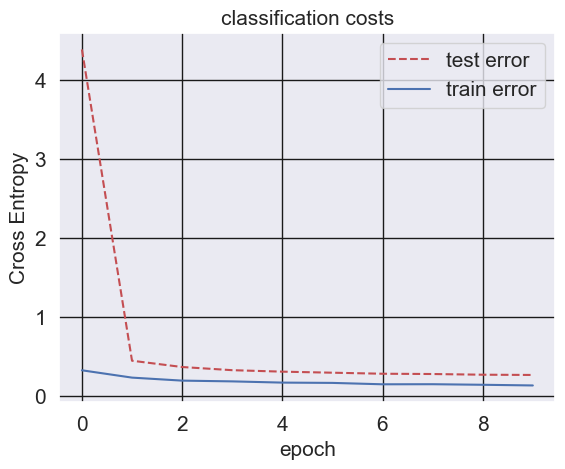

<Figure size 640x480 with 0 Axes>

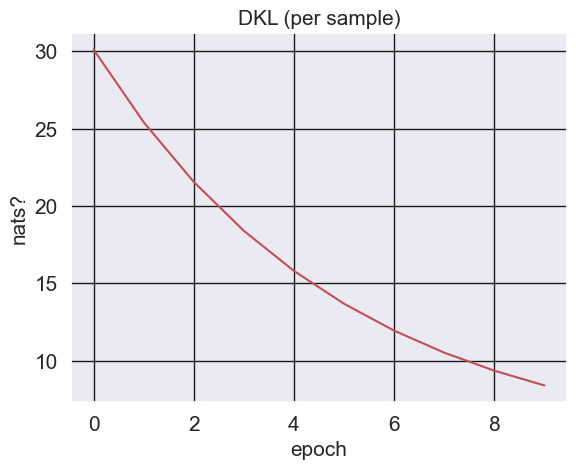

<Figure size 640x480 with 0 Axes>

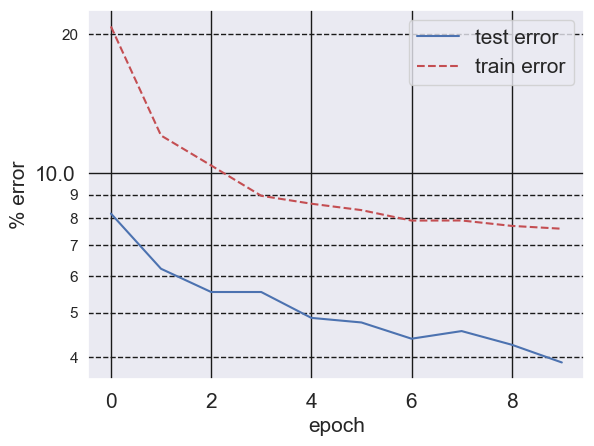

<Figure size 640x480 with 0 Axes>

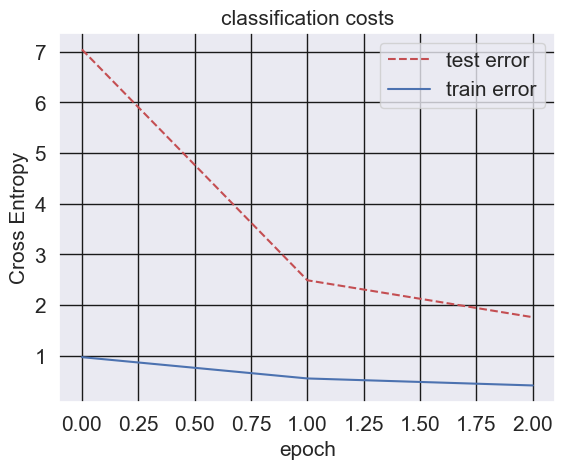

<Figure size 640x480 with 0 Axes>

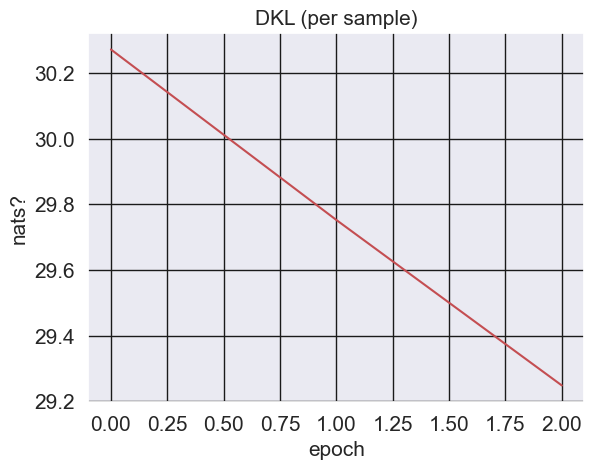

<Figure size 640x480 with 0 Axes>

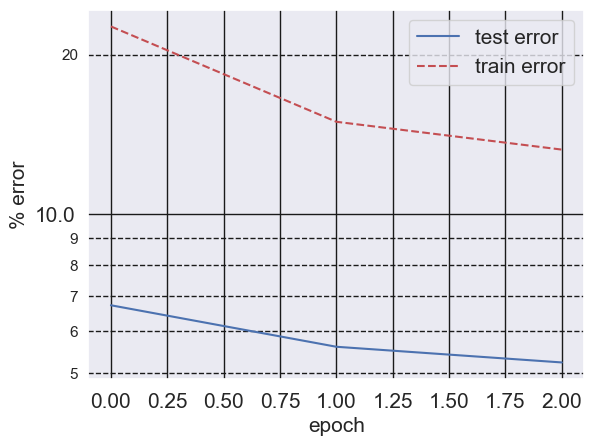

<Figure size 640x480 with 0 Axes>

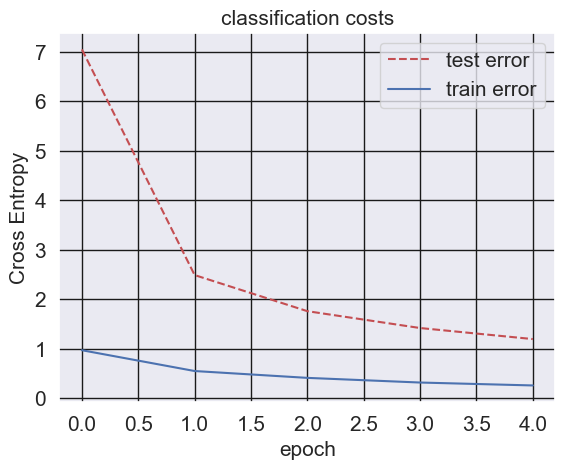

<Figure size 640x480 with 0 Axes>

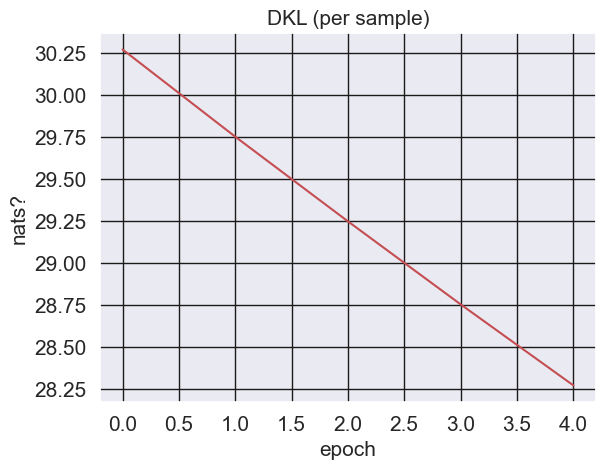

<Figure size 640x480 with 0 Axes>

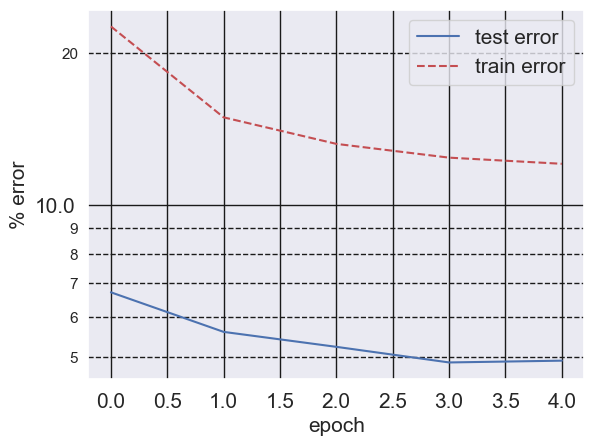

<Figure size 640x480 with 0 Axes>

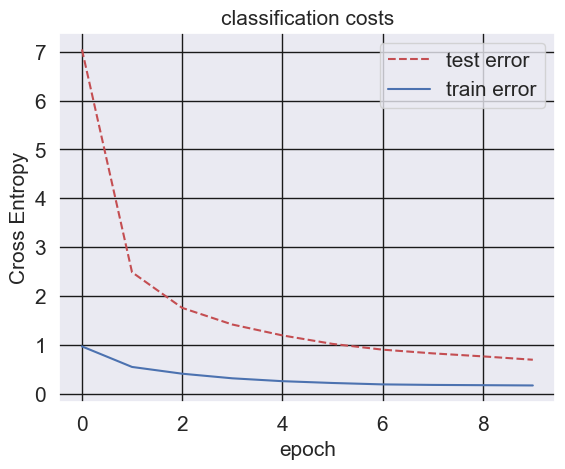

<Figure size 640x480 with 0 Axes>

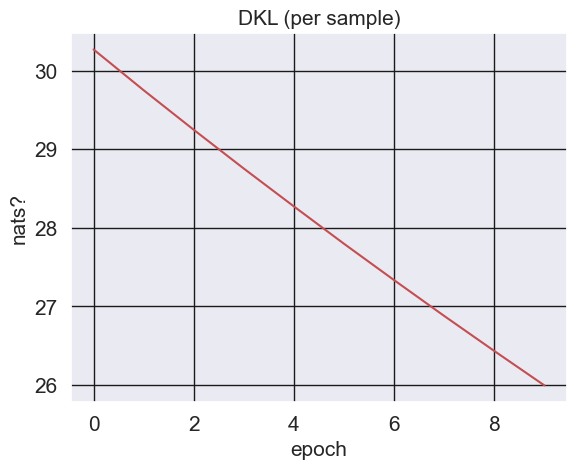

<Figure size 640x480 with 0 Axes>

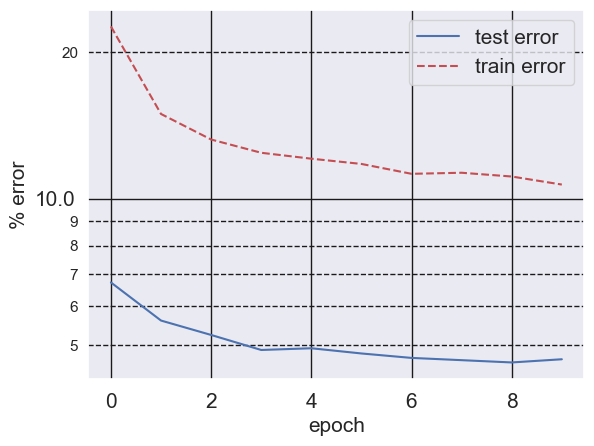

<Figure size 640x480 with 0 Axes>

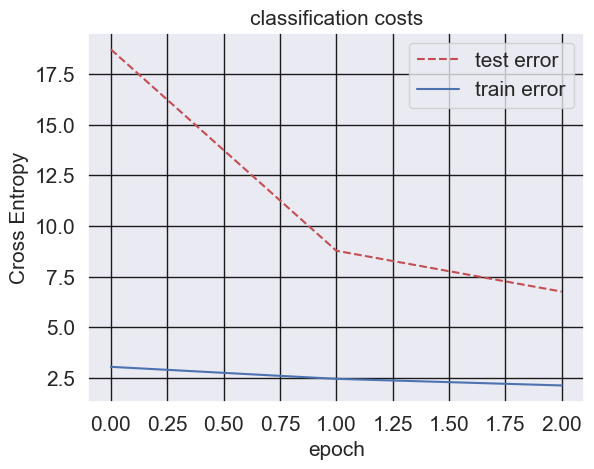

<Figure size 640x480 with 0 Axes>

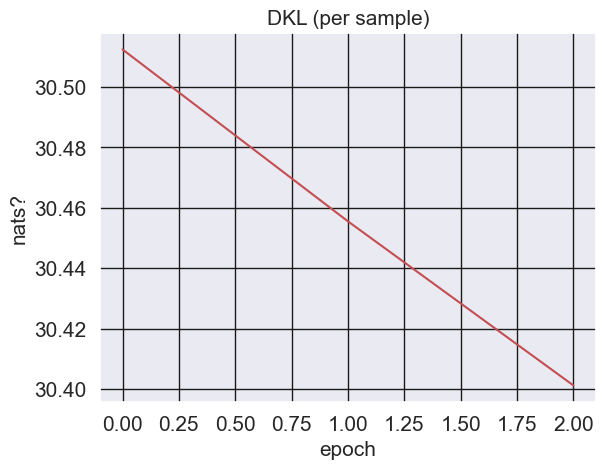

<Figure size 640x480 with 0 Axes>

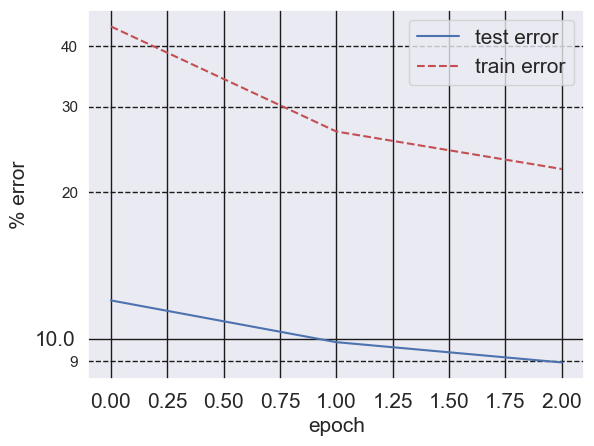

<Figure size 640x480 with 0 Axes>

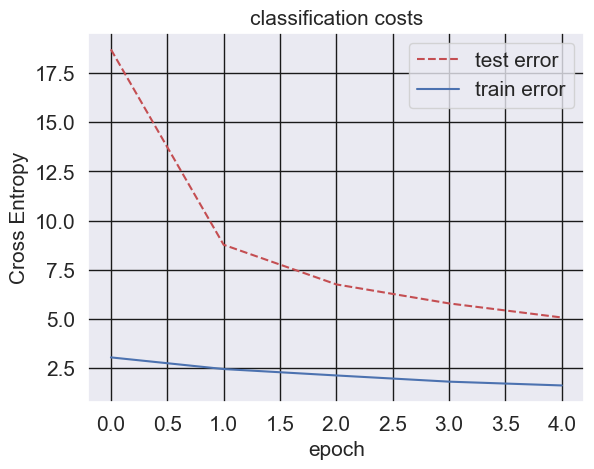

<Figure size 640x480 with 0 Axes>

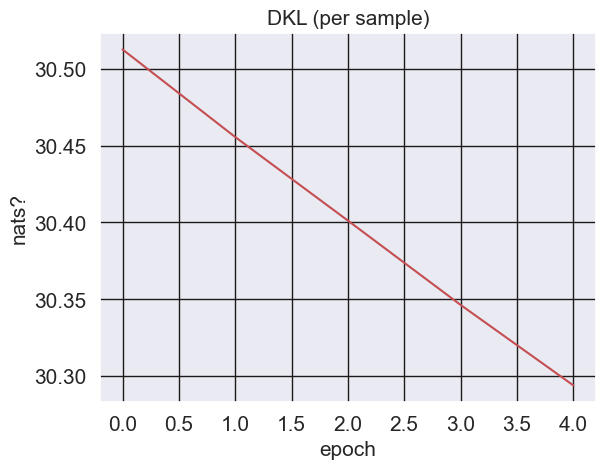

<Figure size 640x480 with 0 Axes>

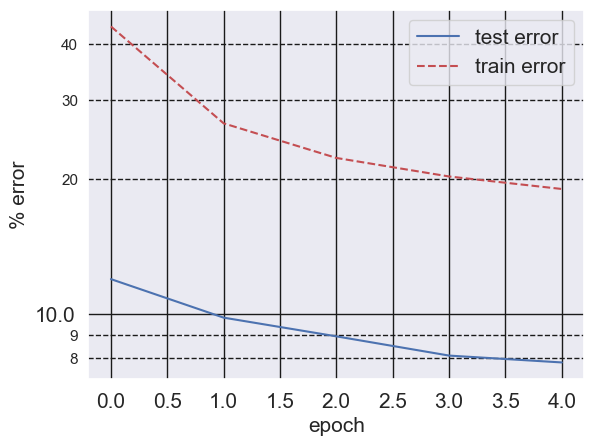

<Figure size 640x480 with 0 Axes>

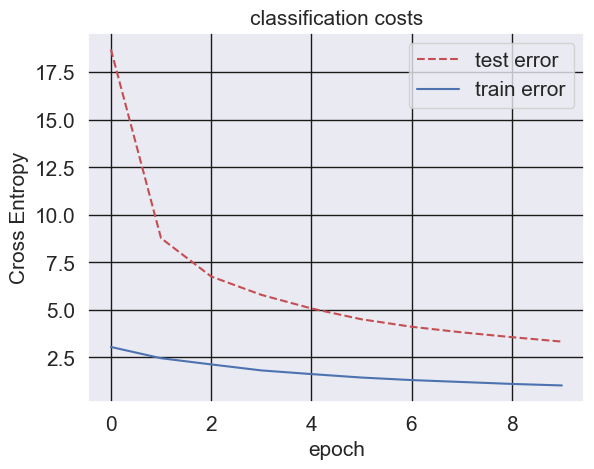

<Figure size 640x480 with 0 Axes>

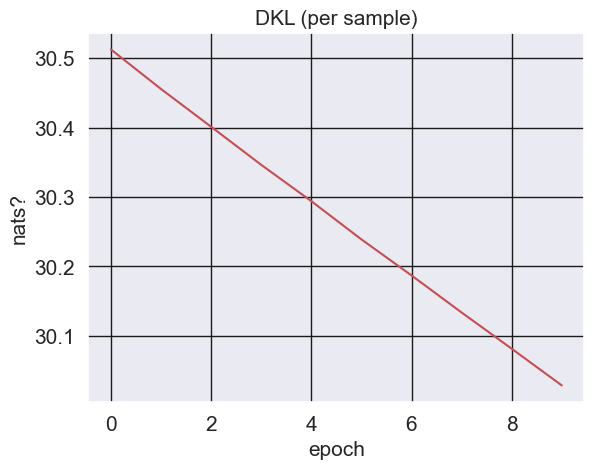

<Figure size 640x480 with 0 Axes>

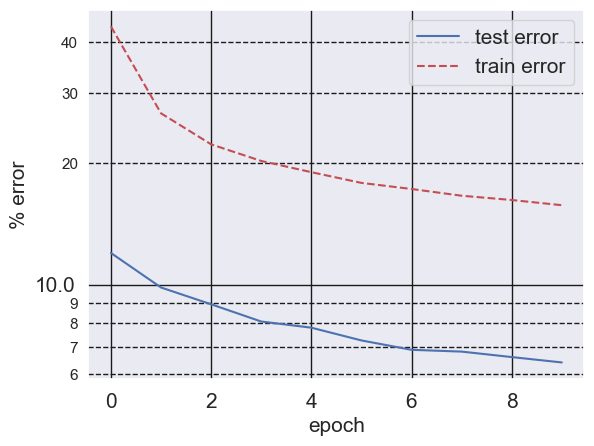

In [19]:
wandb.agent(sweep_id, function=main, count = 45)

## inference with sampling on test set (performed in wandb main function)

In [ ]:
batch_size = 200

if use_cuda:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

else:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=4)
test_cost = 0  # Note that these are per sample
test_err = 0
nb_samples = 0
test_predictions = np.zeros((10000, 10))

Nsamples = 100

net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):
    cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True

    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))
